# HG data

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
import glob
import time
import warnings
import datetime 
import matplotlib.dates as mdates
print("Last updated on ", time.asctime())

Last updated on  Thu Jun 11 20:49:37 2020


In [4]:
import numpy as np
import pandas as pd
import matplotlib

from scipy import stats

In [93]:
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
from c19.data_functions_HG import hg_get_data_ingresos, hg_get_data_pacientes, hg_get_data_age
from c19.HG_analysis import plot_hgi, plot_nh_nu, recovery_time, exitus_time, exitus_group, exitus, hosp_uci, select_age_by_CA_and_sex
from c19.HG_analysis import hist_XY_series, plot_XY_series, plot_pop_age
from c19.HG_analysis import formatter

In [6]:
datapath="/Users/hernando/investigacion/bio/c19/data/HospitalesGalicia"
file = "IngresosCovid.csv"
filep = "PacientesCOVID.csv"
ff =f'{datapath}/{file}'
fp =f'{datapath}/{filep}'
dfi = pd.read_csv(ff, sep='|')

## HGalicia

### ingresos

In [7]:
hgi = hg_get_data_ingresos(ff)
hgi.head()

,pacienteID,ingreso,alta,hosp
0,8,2020-03-18,2020-03-26,HOS
1,9,2020-03-29,2020-04-24,HOS
2,10,2020-03-27,2020-04-07,HOS
3,10,2020-04-14,2020-04-30,HOS
4,12,2020-03-23,2020-04-09,HOS


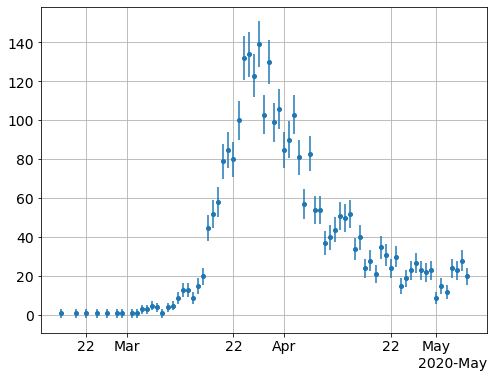

In [8]:
nps = hgi.groupby(['ingreso']).pacienteID.count()
sel = nps.index >= np.datetime64('2020-02-15')
dates, cases = nps.index[sel], nps.values[sel]
plt.figure(figsize = (8, 6))
plt.errorbar(dates, cases, yerr = np.maximum(np.sqrt(cases), 2.4), ls = '', marker = 'o', ms = 4)
formatter(plt.gca()); plt.grid();

### decesos

In [9]:
dfp = hg_get_data_pacientes(fp)
dfp.head()

,pacienteID,ingreso,alta,edad,sexo,code
0,1,2020-03-25,2020-03-30,102,Mujer,EXITUS
1,2,2020-03-27,2020-03-31,101,Mujer,EXITUS
2,3,2020-03-27,2020-04-19,100,Mujer,EXITUS
3,4,2020-04-01,2020-04-24,99,Mujer,EXITUS
4,5,2020-03-28,2020-04-05,99,Mujer,EXITUS


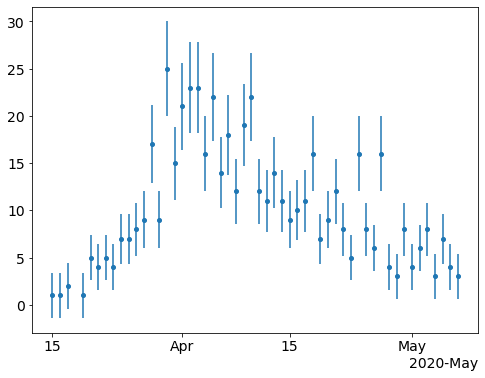

In [10]:
sel = (dfp.code == 'EXITUS') & (dfp.alta.values >= np.datetime64('2020-02-01'))
dfe = dfp[sel] 
nps = dfe.groupby(['alta']).pacienteID.count()
dates, cases = nps.index, nps.values
plt.figure(figsize = (8, 6))
plt.errorbar(dates, cases, yerr = np.maximum(np.sqrt(cases), 2.4), ls = '', marker = 'o', ms = 4)
formatter(plt.gca());

### Exitus time

In [11]:
dfp = hg_get_data_pacientes(fp)
print(set(dfp.code))
print(dfp.head())

{nan, 'EXITUS', 'UCI', 'HOS'}
   pacienteID    ingreso       alta  edad   sexo    code
0           1 2020-03-25 2020-03-30   102  Mujer  EXITUS
1           2 2020-03-27 2020-03-31   101  Mujer  EXITUS
2           3 2020-03-27 2020-04-19   100  Mujer  EXITUS
3           4 2020-04-01 2020-04-24    99  Mujer  EXITUS
4           5 2020-03-28 2020-04-05    99  Mujer  EXITUS


In [12]:
def get_cases(df, index = 'ingreso'):
    nps = df.groupby([index]).pacienteID.count()
    dates, cases = nps.index, nps.values
    return dates, cases

In [13]:
import c19.cfit as cfit

def fchi2(xs, ys):
    nscale = np.sum(ys)
    yerr   = np.maximum(np.sqrt(ys), 2.4)
    
    def _fun(pars):
        c, m = pars[0], pars[1]
        ds   = (nscale * stats.weibull_min(c, scale = m).pdf(xs) - ys)/yerr
        return ds * ds
    
    return _fun

In [14]:
sel = (dfp.code == 'EXITUS') & (dfp.alta.values >= np.datetime64('2020-02-01'))
dtime = (dfp[sel].alta.values - dfp[sel].ingreso.values)/ np.timedelta64(1, 'D')
print(np.mean(dtime), np.std(dtime), len(dtime))

tm     = np.mean(dtime)
nscale = len(dtime)

ndays  = int(np.max(dtime))

ys, xs = np.histogram(dtime, ndays, (0, ndays))
xs = 0.5 * (xs[1 :] + xs[:-1])

9.622920517560074 8.208587967754653 541


fit weibull  [ 1.23213583 11.18175588]
weibull mean  10.22569210720256 tm  9.622920517560074


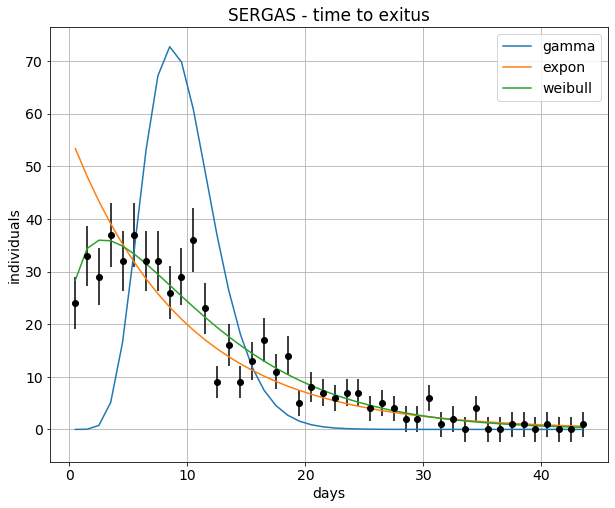

In [15]:
ffun = fchi2(xs, ys)
pars = np.array((1.5, tm))


res = cfit.minimize(pars, ffun)
print('fit weibull ', res)

ndays = 40
plt.errorbar(xs, ys, yerr = np.maximum(2.4, np.sqrt(ys)), ls = '', marker = 'o', c = 'black')

plt.plot(xs, nscale * stats.gamma(tm).pdf(xs), ls = '-', label = 'gamma')
plt.plot(xs, nscale * stats.expon(scale = tm).pdf(xs), ls = '-', label = 'expon')
plt.plot(xs, nscale * stats.weibull_min(res[0], scale = res[1]).pdf(xs), ls = '-', label = 'weibull')
plt.grid(); plt.xlabel('days'); plt.ylabel('individuals'); plt.title('SERGAS - time to exitus')
plt.legend();

nmean = np.sum(xs * stats.weibull_min(res[0], scale = res[1]).pdf(xs))
print('weibull mean ', nmean, 'tm ', tm)

weibull mean  10.22569210720256 tm  9.622920517560074


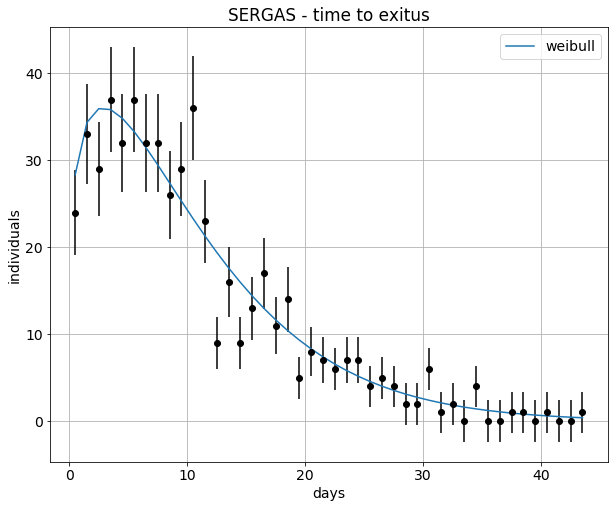

In [16]:
ndays = 40
plt.errorbar(xs, ys, yerr = np.maximum(2.4, np.sqrt(ys)), ls = '', marker = 'o', c = 'black')
plt.plot(xs, nscale * stats.weibull_min(res[0], scale = res[1]).pdf(xs), ls = '-', label = 'weibull')
plt.grid(); plt.xlabel('days'); plt.ylabel('individuals'); plt.title('SERGAS - time to exitus')
plt.legend();

nmean = np.sum(xs * stats.weibull_min(res[0], scale = res[1]).pdf(xs))
print('weibull mean ', nmean, 'tm ', tm)

## Cases vs time - Pandemic evolution

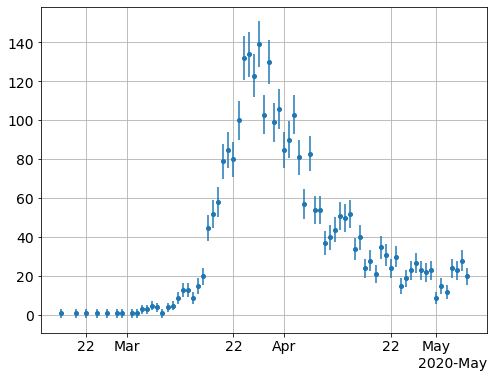

In [17]:
nps = hgi.groupby(['ingreso']).pacienteID.count()
sel = nps.index >= np.datetime64('2020-02-15')
dates, cases = nps.index[sel], nps.values[sel]
ucases       = np.maximum(2.4, np.sqrt(cases))
plt.figure(figsize = (8, 6))
plt.errorbar(dates, cases, yerr = np.maximum(np.sqrt(cases), 2.4), ls = '', marker = 'o', ms = 4)
formatter(plt.gca()); plt.grid();

## KF

#### Tr 2 days

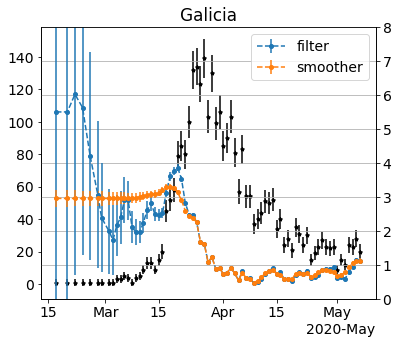

In [19]:
import c19.useir     as us
import c19.useir_ana as usa
blind = True
dates_blind = ('2020-03-25','2020-04-05') if blind is True else ('2020-07-25','2020-08-05')
times = (1.9, 5.5, 10.)
rs_smooth, rs_filter = us.useir_kfs_comomo(dates, cases, ucases, times, 
                                           dates_blind = dates_blind, q0 = 1.e-4)
usa.plot_data_kfs_rs(dates, cases, rs_filter, rs_smooth = rs_smooth, ucases = ucases)
plt.title('Galicia');

#### 3 days

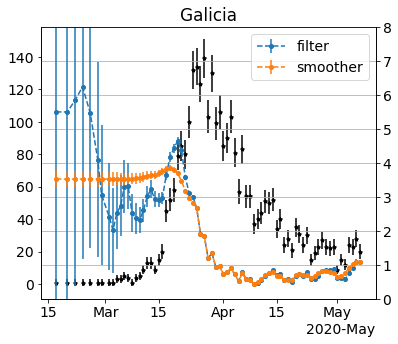

In [22]:
times = (3, 5.5, 10.)
rs_smooth, rs_filter = us.useir_kfs_comomo(dates, cases, ucases, times, 
                                           dates_blind = dates_blind, q0 = 1.e-4)
usa.plot_data_kfs_rs(dates, cases, rs_filter, rs_smooth = rs_smooth, ucases = ucases)
plt.title('Galicia');

### Chi2 fit

In [24]:
nn = {'Madrid': 6578079, 'Castilla y Leon': 2409164, 'Castilla La Mancha': 2026807, 
      'Cataluna': 7600065, 'C. Valenciana': 4963703, 'Aragon': 1308728, 'Pais Vasco': 2199088, 
      'Navarra': 647554, 'La Rioja': 315675, 'Cantabria': 580229, 'Asturias': 1028244, 
      'Galicia': 2701743, 'Murcia': 1478509, 'Andalucia': 8384408, 'Extremadura': 1072863, 
      'Baleares': 1128908, 'Canarias': 2127685}

n0  = nn['Galicia']

### fit useirqr - initial guess

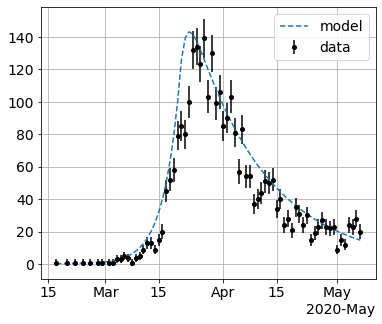

In [170]:
import c19.useir_ana as usa

kpars =  {'t0': 18.0, 'beta': 1.78, 'gamma': 0.30, 'tr': 2., 'ti': 5.0, 
          'n': n0, 'phi': 0.1, 's1': 0.005}
fmodel = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

### fit useirqr  

5.173021334516306 {'t0': 18.0, 'beta': 1.78, 'gamma': 0.3, 'tr': 2.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.1, 's1': 0.005}
1.9864394826420986 {'t0': 18.0, 'beta': 1.6652886705733985, 'gamma': 0.27882094203723695, 'tr': 2.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.1, 's1': 0.005}
1.986437925167277 {'t0': 18.112263390662662, 'beta': 1.6652886705733985, 'gamma': 0.27882094203723695, 'tr': 2.0000734679191607, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.1, 's1': 0.005}
1.9864378527002537 {'t0': 18.112263390662662, 'beta': 1.6652504261039482, 'gamma': 0.27882094203723695, 'tr': 2.0000734679191607, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.1, 's1': 0.004987249791622162}
1.9862499082583787 {'t0': 18.112263390662662, 'beta': 1.6652504261039482, 'gamma': 0.27920612758444735, 'tr': 2.0000734679191607, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.09970899863750676, 's1': 0.004987249791622162}


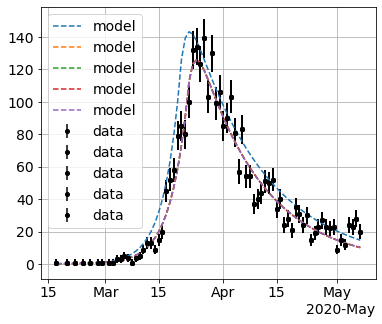

In [29]:
masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)
print(chi2, kpars)

1.9862499082583787 {'t0': 18.112263390662662, 'beta': 1.6652504261039482, 'gamma': 0.27920612758444735, 'tr': 2.0000734679191607, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.09970899863750676, 's1': 0.004987249791622162}


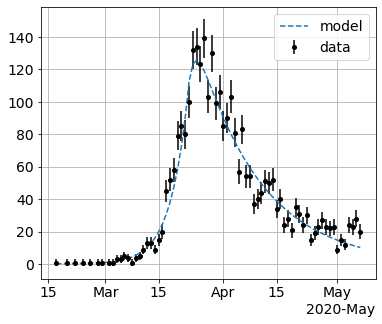

In [30]:
usa.plot_data_model(dates, cases, fmodel)
print(chi2, kpars)

In [ ]:
## TR-scan [1.5, 4.5] dias

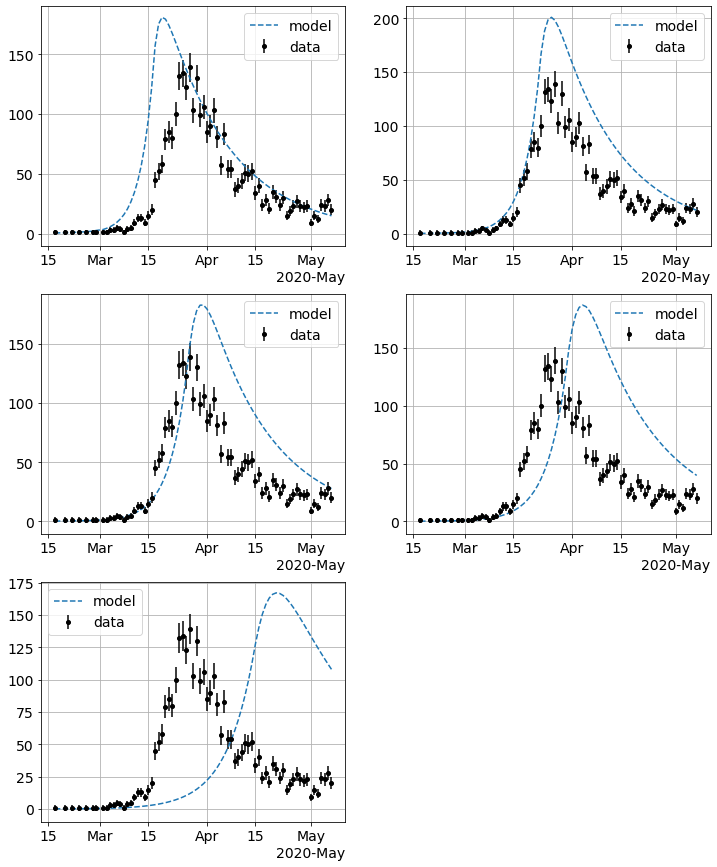

In [78]:
trs = [2., 3., 4., 5., 10]
masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

plt.figure(figsize = (6 * ncols, 5 * nrows))

for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=32, min=32)

tr  1.0 , chi2 2.7149338355221704 , pars  {'t0': 7.881841088724746, 'beta': 3.9729011026978065, 'gamma': 0.5250633667960427, 'tr': 1.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.029153589574275836, 's1': 0.009343251150683834}
tr  1.5 , chi2 2.375750184065839 , pars  {'t0': 12.568397937652517, 'beta': 2.685265867013149, 'gamma': 0.3859936296350791, 'tr': 1.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.03977700291675633, 's1': 0.00910729149690645}
tr  2 , chi2 2.009361502742644 , pars  {'t0': 15.550087031114987, 'beta': 2.012545329202588, 'gamma': 0.2880931738324265, 'tr': 2.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.051204532059903385, 's1': 0.008457087579471945}
tr  2.5 , chi2 1.9840994190523549 , pars  {'t0': 18.909717291061696, 'beta': 1.6075904424938252, 'gamma': 0.2328018347159732, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06453649448921864, 's1': 0.007647434911087145}
tr  3.0 , chi2 2.0758831874819865 , pars  {'t0': 21.293191282321416, 'beta': 1.3402810882608271, 'gamma': 0.19358707253820123,

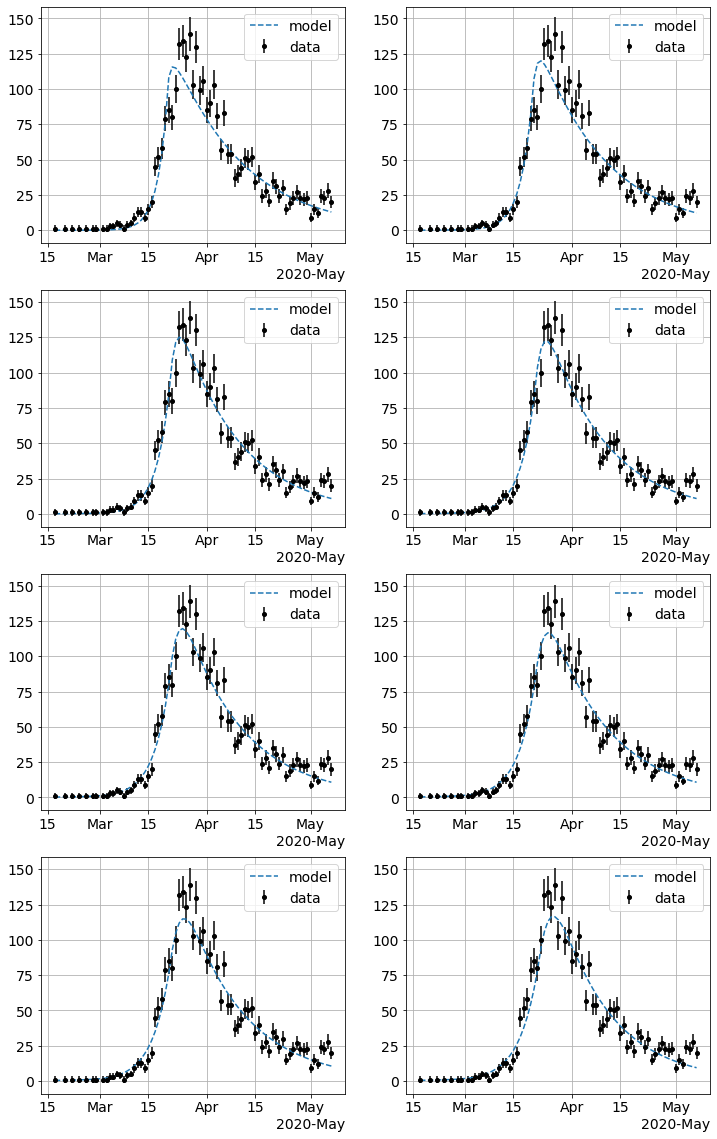

In [96]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma'))
#masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=0, max=40)

tr  1.0 , chi2 2.6472906779200986 , pars  {'t0': 7.890809711719027, 'beta': 3.9708750121462755, 'gamma': 0.5135697808088424, 'tr': 1.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.03106774238718195, 's1': 0.009486521236269366}
tr  1.5 , chi2 2.217834908288579 , pars  {'t0': 11.962281371115921, 'beta': 2.6861447617452736, 'gamma': 0.3683936911502089, 'tr': 1.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.04251611757703784, 's1': 0.008445631439118166}
tr  2 , chi2 2.009357810504871 , pars  {'t0': 15.561294070932517, 'beta': 2.01265783620231, 'gamma': 0.2879323901720026, 'tr': 2.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.05124068783283272, 's1': 0.008314845642688508}
tr  2.5 , chi2 1.9841251164422415 , pars  {'t0': 18.97075541060267, 'beta': 1.6072311385892502, 'gamma': 0.23309518856719202, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06447272832630126, 's1': 0.007629016350911566}
tr  3.0 , chi2 2.0759563423256777 , pars  {'t0': 21.294237395253994, 'beta': 1.3396285330978324, 'gamma': 0.1942357673914859, '

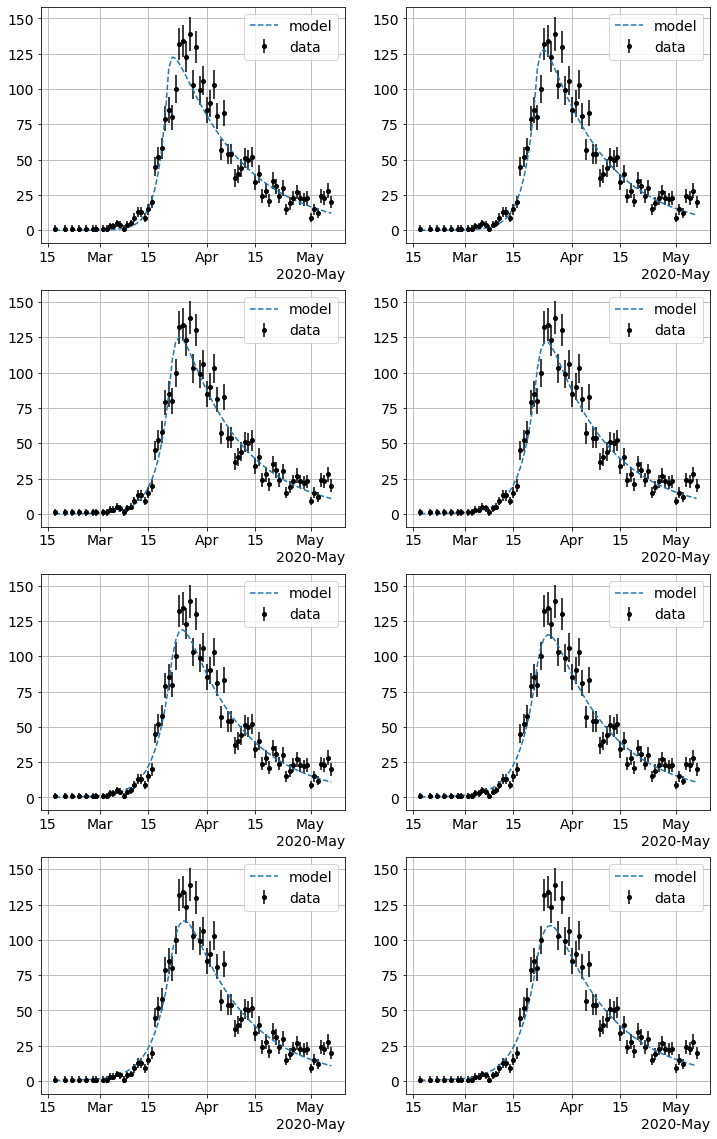

In [98]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
#masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma'))
masks = (('t0', 's1', 'phi'), ('beta', 'gamma'), ('t0',), ('s1', 'beta'), ('phi', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=0, max=32)

tr  1.0 , chi2 2.6365223754600646 , pars  {'t0': 7.904405662485786, 'beta': 3.785940179617271, 'gamma': 0.5108527443122552, 'tr': 1.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.04475758698270263, 's1': 0.009120977821281545}
tr  1.5 , chi2 2.1643866243724292 , pars  {'t0': 12.612315300890716, 'beta': 2.524439744681389, 'gamma': 0.3690084641998802, 'tr': 1.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.05275853307738588, 's1': 0.008842298639828985}
tr  2 , chi2 2.0329628189854816 , pars  {'t0': 15.575937521789093, 'beta': 1.9756277366965393, 'gamma': 0.28790452110709297, 'tr': 2.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.05944596078343016, 's1': 0.008250354001617655}
tr  2.5 , chi2 1.991456057636671 , pars  {'t0': 18.965516188887282, 'beta': 1.6522485396512159, 'gamma': 0.23283519042867218, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.05170389653168015, 's1': 0.00781420603630235}
tr  3.0 , chi2 2.0580385714155858 , pars  {'t0': 21.299203992343628, 'beta': 1.3693022054102455, 'gamma': 0.19376870785600886

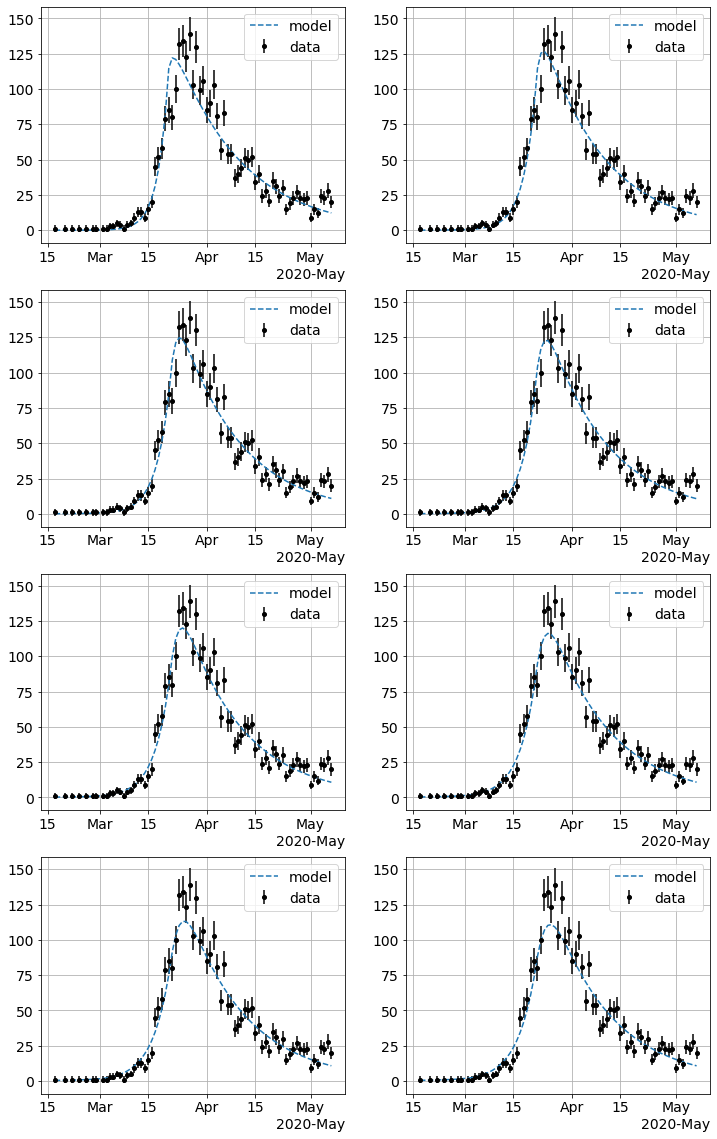

In [99]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
#masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma'))
masks = 2 * (('t0', 's1', 'phi'), ('phi', 'beta', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=0, max=32)

tr  1.0 , chi2 2.6935710773932606 , pars  {'t0': 7.883027002817046, 'beta': 4.001752807973608, 'gamma': 0.5148284929237532, 'tr': 1.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.029154476765364118, 's1': 0.010460444453993661}
tr  1.5 , chi2 2.4092120982023966 , pars  {'t0': 12.576126883180503, 'beta': 2.685271844566177, 'gamma': 0.38599749431816227, 'tr': 1.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.03977899045644109, 's1': 0.009296303239545407}
tr  2 , chi2 2.037662097580703 , pars  {'t0': 15.549686997758528, 'beta': 2.0124905883434696, 'gamma': 0.28811184067023776, 'tr': 2.0, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.05120499480982071, 's1': 0.008602729083936271}
tr  2.5 , chi2 2.0120779745196185 , pars  {'t0': 18.91601863398605, 'beta': 1.6075621042034984, 'gamma': 0.23277569680700172, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.0645530720843042, 's1': 0.007781985663334925}
tr  3.0 , chi2 2.105159855324906 , pars  {'t0': 21.29280933556098, 'beta': 1.340223830464812, 'gamma': 0.19361269171048207, 

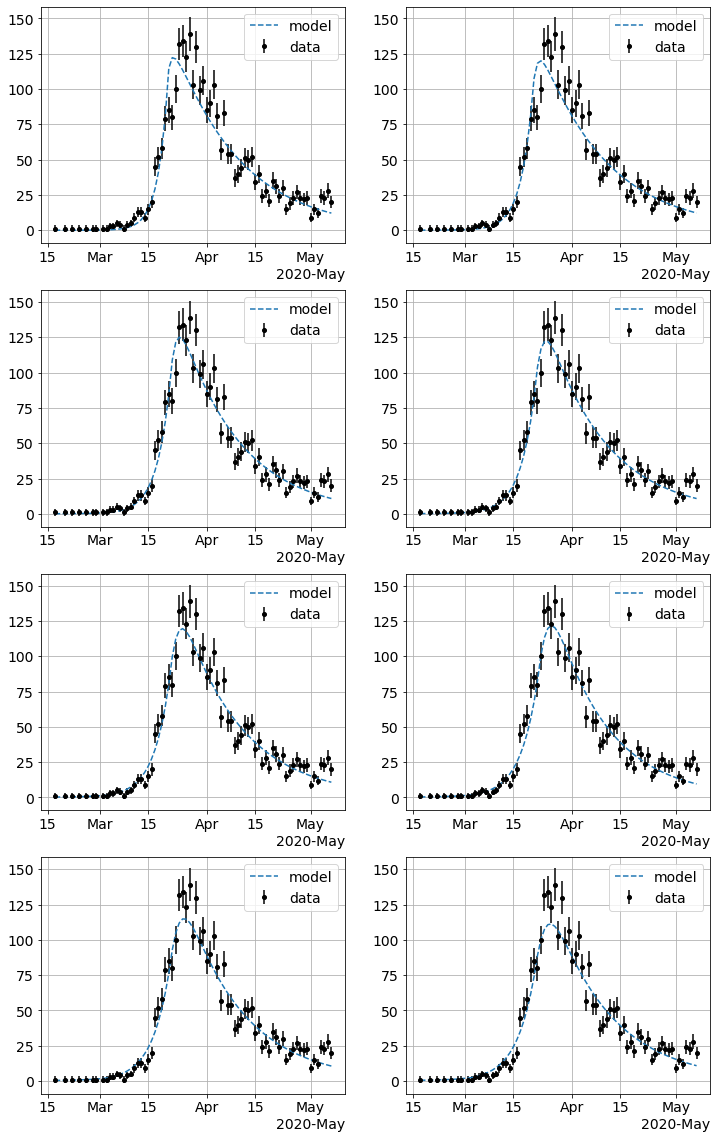

In [100]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
#masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma'))
masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=32, min=32)

tr  1.0 , chi2 2.830614976518228 , pars  {'t0': 7.757471882101578, 'beta': 2.7507974730574536, 'gamma': 0.19482334654326627, 'tr': 3.3567425206274297, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.030525229146659755, 's1': 0.009286745952944951}
tr  1.5 , chi2 2.120730956005488 , pars  {'t0': 12.76575525220166, 'beta': 1.9984897422560985, 'gamma': 0.199025987236087, 'tr': 2.9845601516235956, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.04042155004197957, 's1': 0.00905891785466403}
tr  2 , chi2 2.0126443206012232 , pars  {'t0': 15.606339829648999, 'beta': 1.8250307611583105, 'gamma': 0.23271339384231293, 'tr': 2.473784294716281, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.051245981393606393, 's1': 0.008440768503254745}
tr  2.5 , chi2 1.9676210837986332 , pars  {'t0': 18.89752487186986, 'beta': 1.4427673889316703, 'gamma': 0.17940305082806784, 'tr': 3.1646567868406112, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06463222498733252, 's1': 0.007661234098764798}
tr  3.0 , chi2 2.03930538171296 , pars  {'t0': 21.3040894407628, 

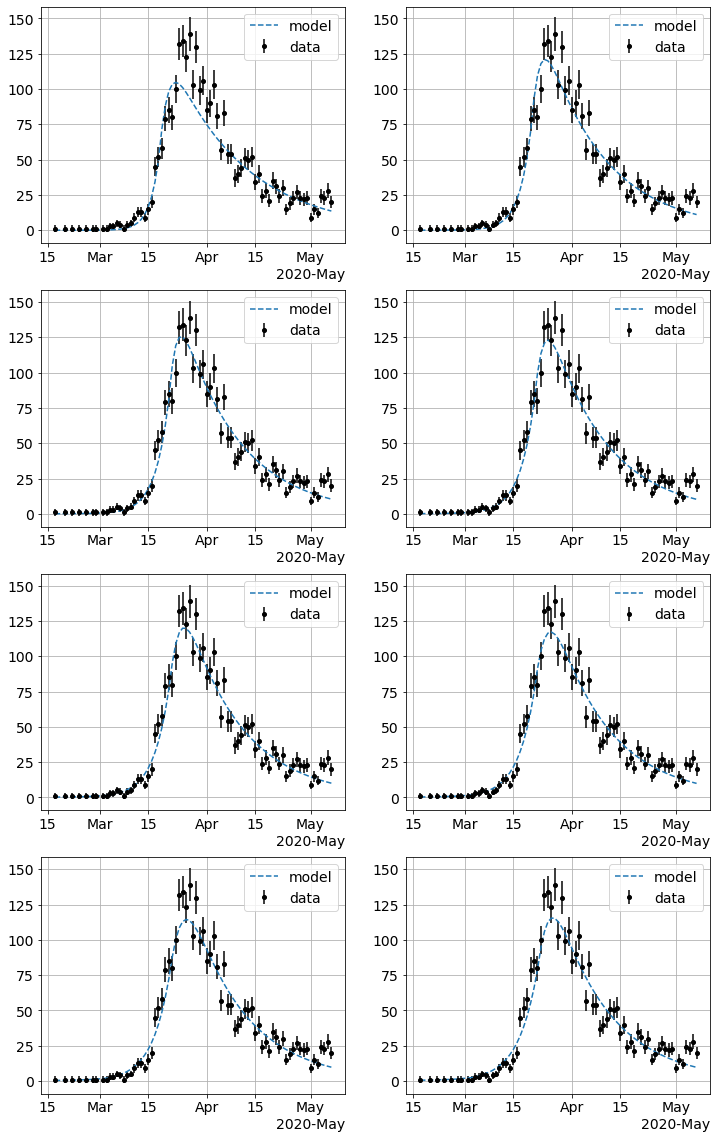

In [101]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma', 'tr'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

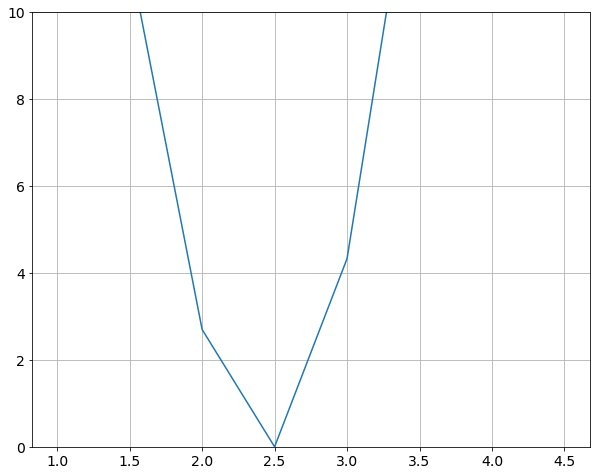

In [118]:
chis = np.array((2.6365223754600646, 2.1643866243724292, 2.0329628189854816, 
                 1.991456057636671, 2.0580385714155858, 2.2183726844014604, 2.4197976070719043, 2.6081779225572044))
chiss = 65 * (chis - np.min(chis))
plt.plot(trs, chiss); plt.grid(); plt.ylim((0., 10));

In [178]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma', 'tr'))

def scan_trs(trs, mask, ti = 5.5):
    
    keys = ['t0', 'beta', 'gamma', 'tr', 'ti', 'n', 'phi', 's1', 'chi2']
    dpars = {}
    for key in keys: dpars[key] = []
        
    ncols, nrows = 2, int(len(trs)/2)
    if (len(trs) % nrows != 0): nrows += 1

    tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
    plt.figure(figsize = (6 * ncols, 5 * nrows))
    chis = []
    for i, tr in enumerate(trs):
        kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
                  'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
        for imask in masks:
            tbar.value += 1
            kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
        for key in kpars.keys():
            dpars[key].append(kpars[key])
        dpars['chi2'].append(chi2)
        dpars[tr] = kpars.copy(); dpars[tr]['chi2'] = chi2 
        #print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
        fmodel = usa.useirqr_fmodel(kpars = kpars)
        ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
        usa.plot_data_model(dates, cases, fmodel)
    
    chis = np.array(dpars['chi2'])
    print(chis)
    plt.figure(figsize = (8, 6))
    dchis =  (len(cases) - 6) * ( chis - np.min(chis))
    plt.plot(trs, dchis); plt.title(r'$\Delta \chi2$'); plt.grid(); plt.ylim((0., 10));
    return dpars 

IntProgress(value=0, max=40)

tr  1.5 , chi2 2.4092120982023966 , pars  {'t0': 12.576126883180503, 'beta': 2.685271844566177, 'gamma': 0.38599749431816227, 'tr': 1.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.03977899045644109, 's1': 0.009296303239545407}
tr  1.7777777777777777 , chi2 2.1057268967417486 , pars  {'t0': 12.682305470195157, 'beta': 2.2724576974352813, 'gamma': 0.31837543348733865, 'tr': 1.7777777777777777, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06587111852137599, 's1': 0.005854369999226091}
tr  2.0555555555555554 , chi2 2.0273406664276385 , pars  {'t0': 16.597937931203504, 'beta': 1.9026310880947426, 'gamma': 0.28146433633812357, 'tr': 2.0555555555555554, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.05657486681105027, 's1': 0.008314785023909345}
tr  2.3333333333333335 , chi2 2.0048080480454047 , pars  {'t0': 17.484418704146925, 'beta': 1.7226840871465718, 'gamma': 0.2490392245424548, 'tr': 2.3333333333333335, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06096141432176241, 's1': 0.008049332467222062}
tr  2.611111111111111 , chi2

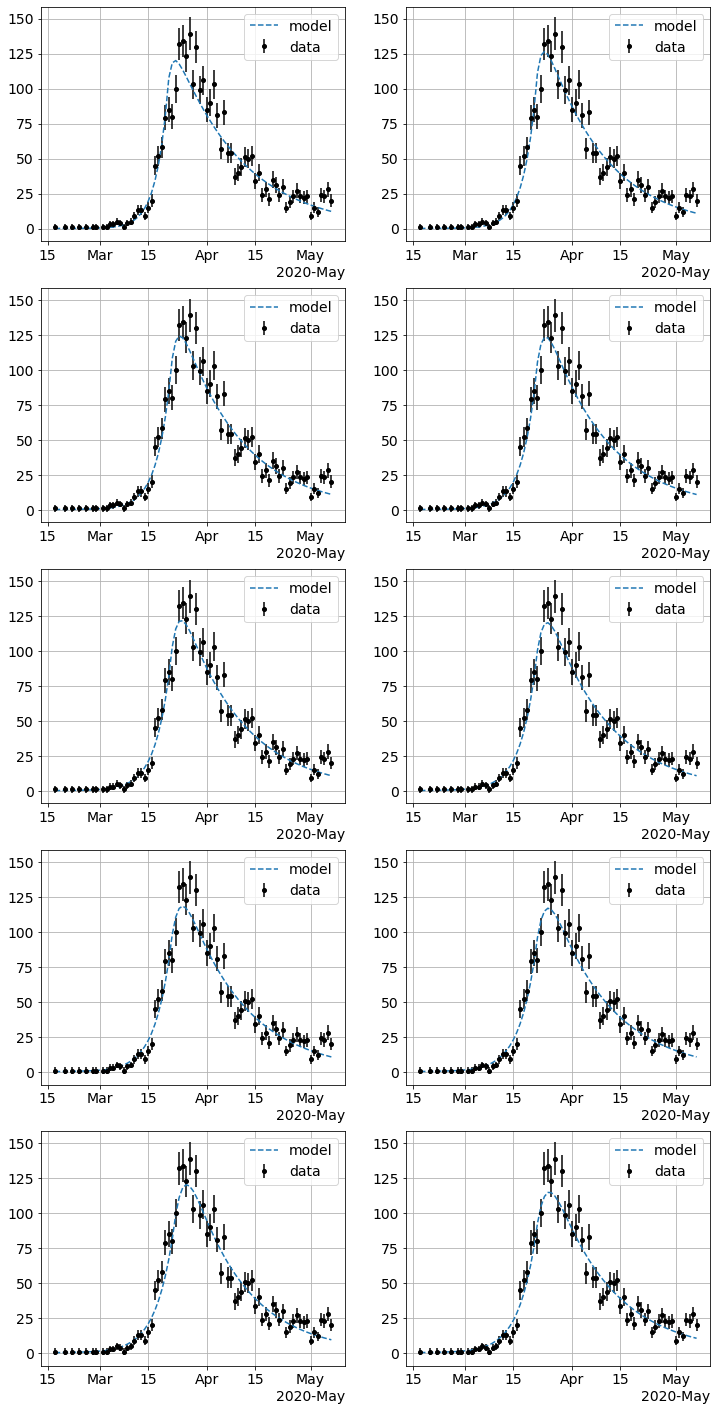

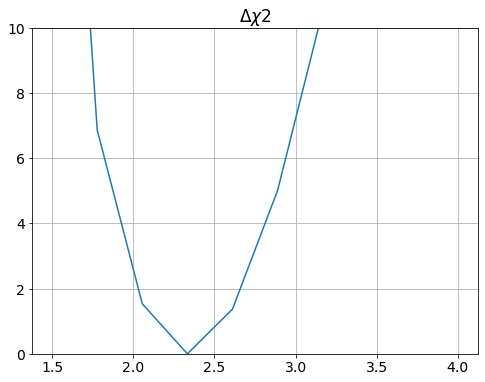

In [169]:
trs = np.linspace(1.5, 4., 10)
masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))
dpars = scan_trs(trs, masks);

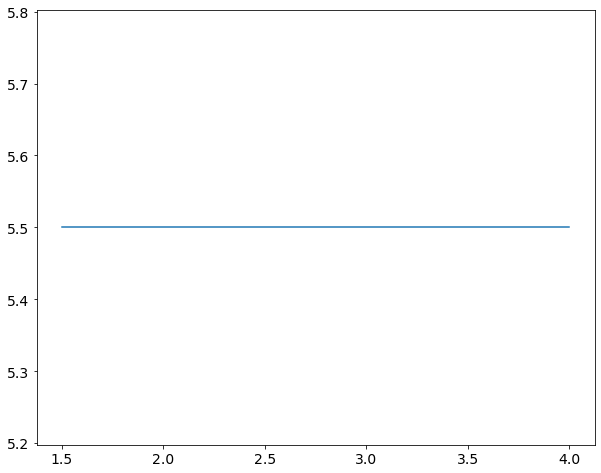

In [177]:
plt.plot(dpars['tr'], dpars[''])

IntProgress(value=0, max=40)

[2.4092121  2.37056603 2.07617511 2.01247996 2.00514204 2.0249468
 2.06369777 2.12731757 2.19506371 2.23726037]


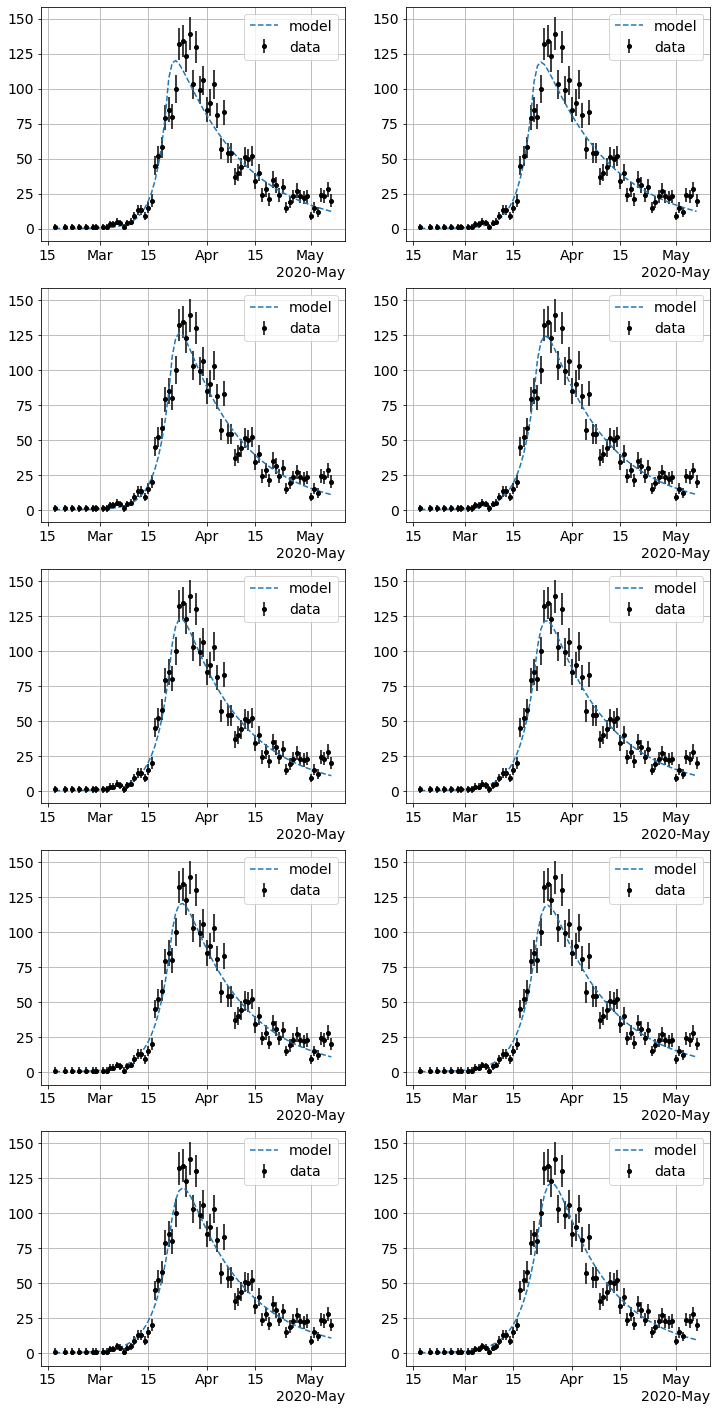

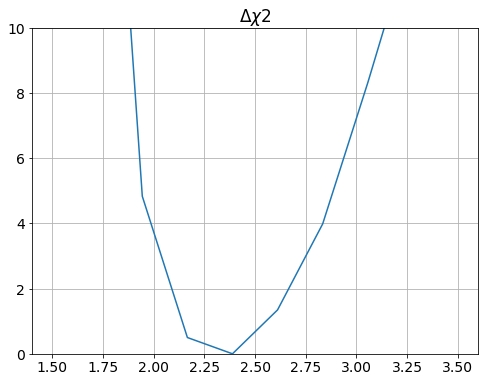

In [179]:
trs = np.linspace(1.5, 3.5, 10)
masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))
dpars = scan_trs(trs, masks, ti = 5.);

### Scan in Ti

IntProgress(value=32, min=32)

tr  2.5 , chi2 2.0698470937900515 , pars  {'t0': 12.382965194142672, 'beta': 1.5808456011238419, 'gamma': 0.25726691023111825, 'tr': 2.5, 'ti': 4.0, 'n': 2701743.0, 'phi': 0.0554557386894492, 's1': 0.0077404985817045215}
tr  2.5 , chi2 1.9960037332039111 , pars  {'t0': 14.37272545281445, 'beta': 1.5915034250888636, 'gamma': 0.2488581911421417, 'tr': 2.5, 'ti': 4.5, 'n': 2701743.0, 'phi': 0.058872523894804046, 's1': 0.007866877537260487}
tr  2.5 , chi2 1.967575208684381 , pars  {'t0': 16.558912491620006, 'beta': 1.5994085527314683, 'gamma': 0.24068893082310122, 'tr': 2.5, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06216155052893389, 's1': 0.007555839030037478}
tr  2.5 , chi2 1.9840994190523549 , pars  {'t0': 18.909717291061696, 'beta': 1.6075904424938252, 'gamma': 0.2328018347159732, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06453649448921864, 's1': 0.007647434911087145}
tr  2.5 , chi2 2.043534267076887 , pars  {'t0': 20.636647218375003, 'beta': 1.615193082541441, 'gamma': 0.2251685403732

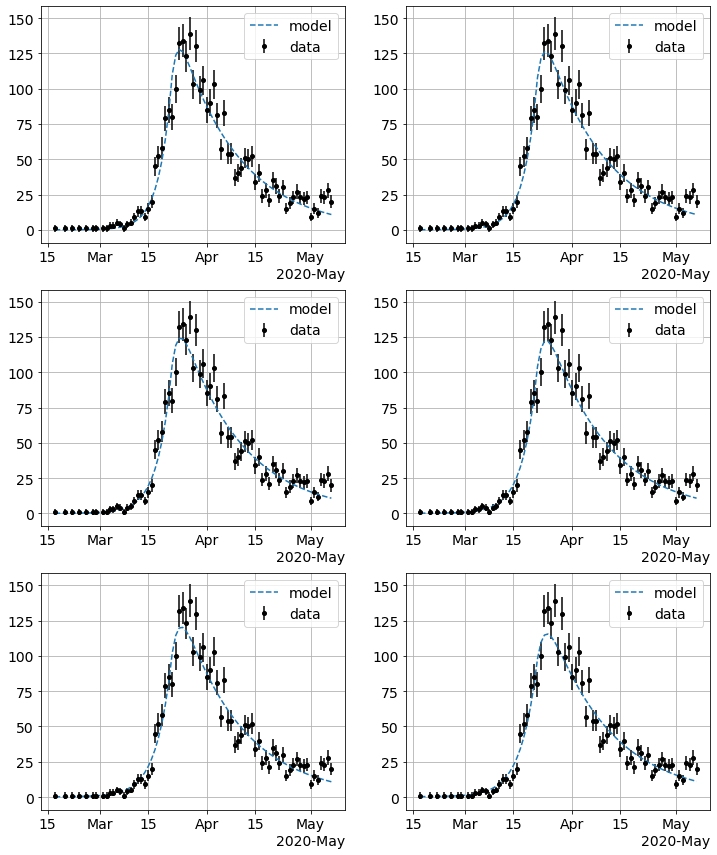

In [104]:
tis = [4., 4.5, 5., 5.5, 6., 6.5]
tr  = 2.5
masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma'))
#masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma',)

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, ti in enumerate(tis):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=0, max=32)

tr  2.5 , chi2 2.2208612534117163 , pars  {'t0': 11.235372916638259, 'beta': 1.845834114175178, 'gamma': 0.3381195497619326, 'tr': 1.804961484112733, 'ti': 4.0, 'n': 2701743.0, 'phi': 0.05481972809281168, 's1': 0.00795156505553703}
tr  2.5 , chi2 2.0110832683340543 , pars  {'t0': 14.617106296556397, 'beta': 1.4946648752317548, 'gamma': 0.21388879891250842, 'tr': 2.882684457176629, 'ti': 4.5, 'n': 2701743.0, 'phi': 0.05906680766018382, 's1': 0.007884418093604666}
tr  2.5 , chi2 1.9696999330972809 , pars  {'t0': 16.593672153737607, 'beta': 1.4692085556443786, 'gamma': 0.19610657766195452, 'tr': 3.0204311391764165, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06221457098911077, 's1': 0.007551103481100599}
tr  2.5 , chi2 1.9676210837986332 , pars  {'t0': 18.89752487186986, 'beta': 1.4427673889316703, 'gamma': 0.17940305082806784, 'tr': 3.1646567868406112, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06463222498733252, 's1': 0.007661234098764798}
tr  2.5 , chi2 2.002049233793711 , pars  {'t0': 20.65413255906

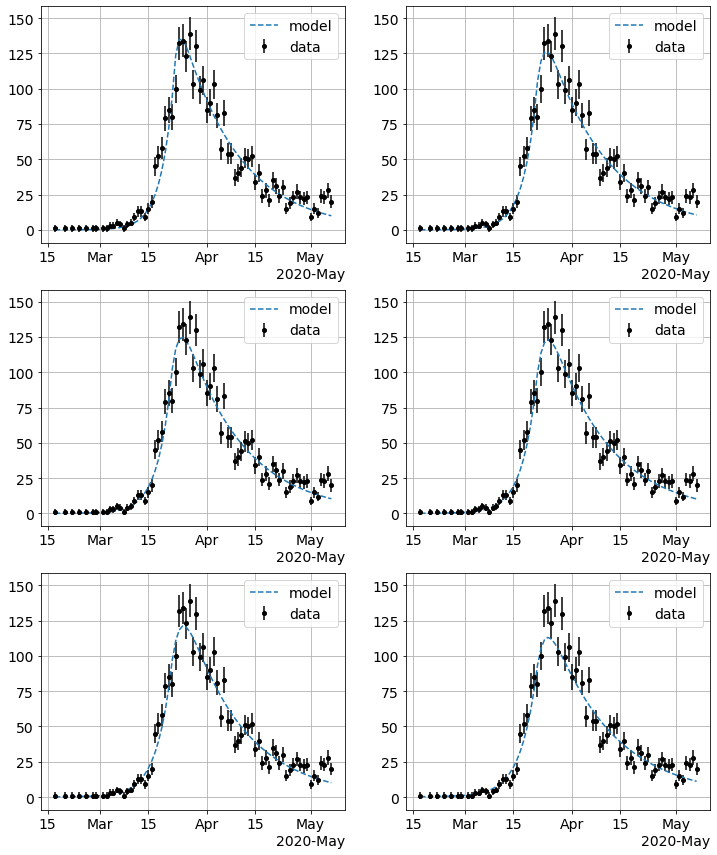

In [106]:
tis = [4., 4.5, 5., 5.5, 6., 6.5]
tr  = 2.5
masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma', 'tr'))
#masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma',)

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, ti in enumerate(tis):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=0, max=40)

tr  2.5 , chi2 2.0783084931411846 , pars  {'t0': 12.173468082170723, 'beta': 1.5919189242281038, 'gamma': 0.25697356063873716, 'tr': 2.5, 'ti': 4.0, 'n': 2701743.0, 'phi': 0.05265789764656766, 's1': 0.008040364404738803}
tr  2.5 , chi2 1.9962009894600168 , pars  {'t0': 14.280689717237426, 'beta': 1.5922316249130133, 'gamma': 0.24869278705055212, 'tr': 2.5, 'ti': 4.5, 'n': 2701743.0, 'phi': 0.058758356742625584, 's1': 0.00789822223530168}
tr  2.5 , chi2 1.9675725683702576 , pars  {'t0': 16.56685301956524, 'beta': 1.5993987798726066, 'gamma': 0.24074588747848719, 'tr': 2.5, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06214332444065521, 's1': 0.007475401939218106}
tr  2.5 , chi2 1.9841251164422415 , pars  {'t0': 18.97075541060267, 'beta': 1.6072311385892502, 'gamma': 0.23309518856719202, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.06447272832630126, 's1': 0.007629016350911566}
tr  2.5 , chi2 2.0435493887407734 , pars  {'t0': 20.67120506849307, 'beta': 1.6145716220045787, 'gamma': 0.22582040944

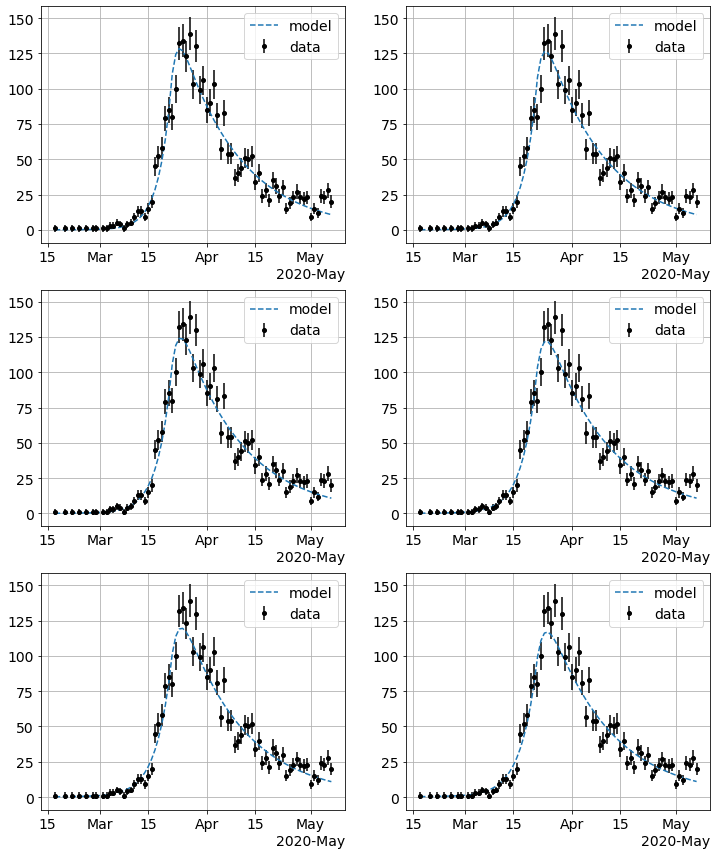

In [108]:
tis = [4., 4.5, 5., 5.5, 6., 6.5]
tr  = 2.5
masks = (('t0', 's1', 'phi'), ('beta', 'gamma'), ('t0',), ('s1', 'beta'), ('phi', 'gamma'))
#masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, ti in enumerate(tis):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

IntProgress(value=0, max=24)

tr  2.5 , chi2 2.099019929814191 , pars  {'t0': 12.386049525592936, 'beta': 1.5808827671029984, 'gamma': 0.25723905148612447, 'tr': 2.5, 'ti': 4.0, 'n': 2701743.0, 'phi': 0.055448600759888625, 's1': 0.007554716254490607}
tr  2.5 , chi2 2.0239127902599043 , pars  {'t0': 14.609382750920886, 'beta': 1.5909446433256564, 'gamma': 0.24882909621585142, 'tr': 2.5, 'ti': 4.5, 'n': 2701743.0, 'phi': 0.059037327802218376, 's1': 0.007758505290888843}
tr  2.5 , chi2 1.9952853159813528 , pars  {'t0': 16.56680034155614, 'beta': 1.5994681029521827, 'gamma': 0.24068962194140336, 'tr': 2.5, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06215523449638909, 's1': 0.007587078906700054}
tr  2.5 , chi2 2.0120779745196185 , pars  {'t0': 18.91601863398605, 'beta': 1.6075621042034984, 'gamma': 0.23277569680700172, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.0645530720843042, 's1': 0.007781985663334925}
tr  2.5 , chi2 2.072302844276194 , pars  {'t0': 20.63582945043924, 'beta': 1.6151709719105773, 'gamma': 0.225216528798

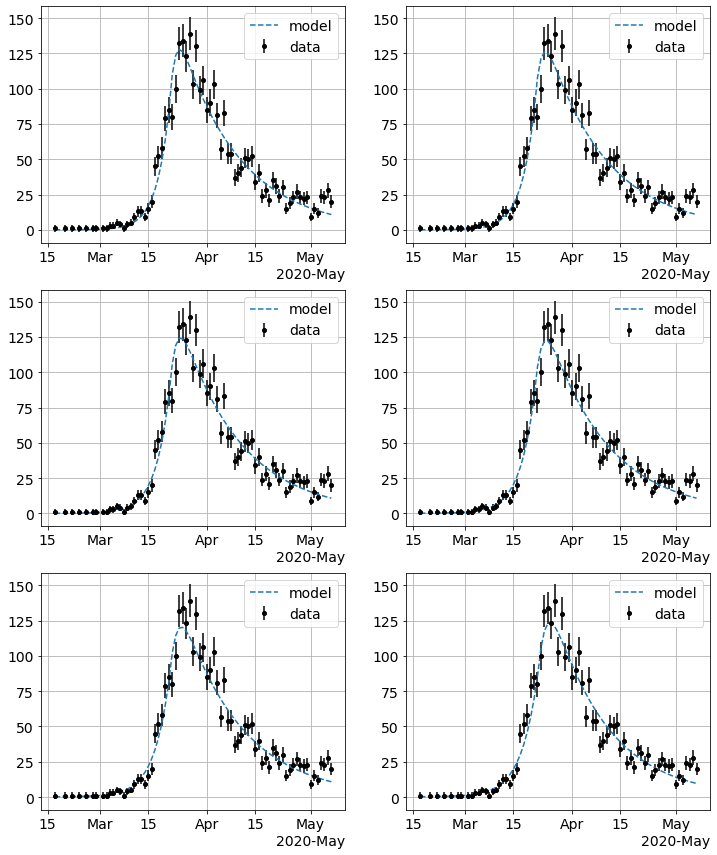

In [110]:
tis = [4., 4.5, 5., 5.5, 6., 6.5]
tr  = 2.5
#masks = (('t0', 's1', 'phi'), ('beta', 'gamma'), ('t0',), ('s1', 'beta'), ('phi', 'gamma'))
masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(tis)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, ti in enumerate(tis):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

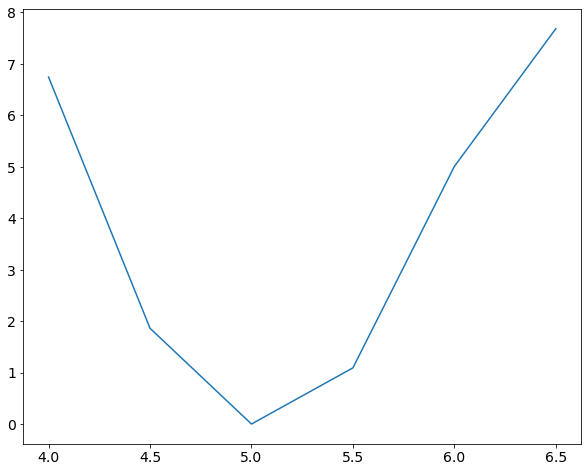

In [115]:
chis = np.array((2.099019929814191, 2.0239127902599043, 1.9952853159813528, 
            2.0120779745196185, 2.072302844276194, 2.1134693740328987))
chiss = (chis - np.min(chis)) * 65
plt.plot(tis, chiss);

In [139]:
def ti_scan(tis, masks, tr = 2.5):

    ncols, nrows = 2, int(len(tis)/2)
    if (len(tis) % nrows != 0): nrows += 1

    tbar = IntProgress(0, max = len(masks) * len(tis)); display(tbar);
    plt.figure(figsize = (6 * ncols, 5 * nrows))
    chis = []
    for i, ti in enumerate(tis):
        kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
                  'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
        for imask in masks:
            tbar.value += 1
            kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
        chis.append(chi2)
        print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
        fmodel = usa.useirqr_fmodel(kpars = kpars)
        ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
        usa.plot_data_model(dates, cases, fmodel)
    
    chis = np.array(chis)
    print(chis)
    plt.figure(figsize = (8, 6))
    dchis =  (len(cases) - 6) * ( chis - np.min(chis))
    plt.plot(tis, dchis); plt.title(r'$\Delta \chi2$'); plt.grid(); plt.ylim((0., 10));
    
    return dchis

IntProgress(value=0, max=24)

tr  2.5 , chi2 2.099019929814191 , pars  {'t0': 12.386049525592936, 'beta': 1.5808827671029984, 'gamma': 0.25723905148612447, 'tr': 2.5, 'ti': 4.0, 'n': 2701743.0, 'phi': 0.055448600759888625, 's1': 0.007554716254490607}
tr  2.5 , chi2 2.0239127902599043 , pars  {'t0': 14.609382750920886, 'beta': 1.5909446433256564, 'gamma': 0.24882909621585142, 'tr': 2.5, 'ti': 4.5, 'n': 2701743.0, 'phi': 0.059037327802218376, 's1': 0.007758505290888843}
tr  2.5 , chi2 1.9952853159813528 , pars  {'t0': 16.56680034155614, 'beta': 1.5994681029521827, 'gamma': 0.24068962194140336, 'tr': 2.5, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06215523449638909, 's1': 0.007587078906700054}
tr  2.5 , chi2 2.0120779745196185 , pars  {'t0': 18.91601863398605, 'beta': 1.6075621042034984, 'gamma': 0.23277569680700172, 'tr': 2.5, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.0645530720843042, 's1': 0.007781985663334925}
tr  2.5 , chi2 2.072302844276194 , pars  {'t0': 20.63582945043924, 'beta': 1.6151709719105773, 'gamma': 0.225216528798

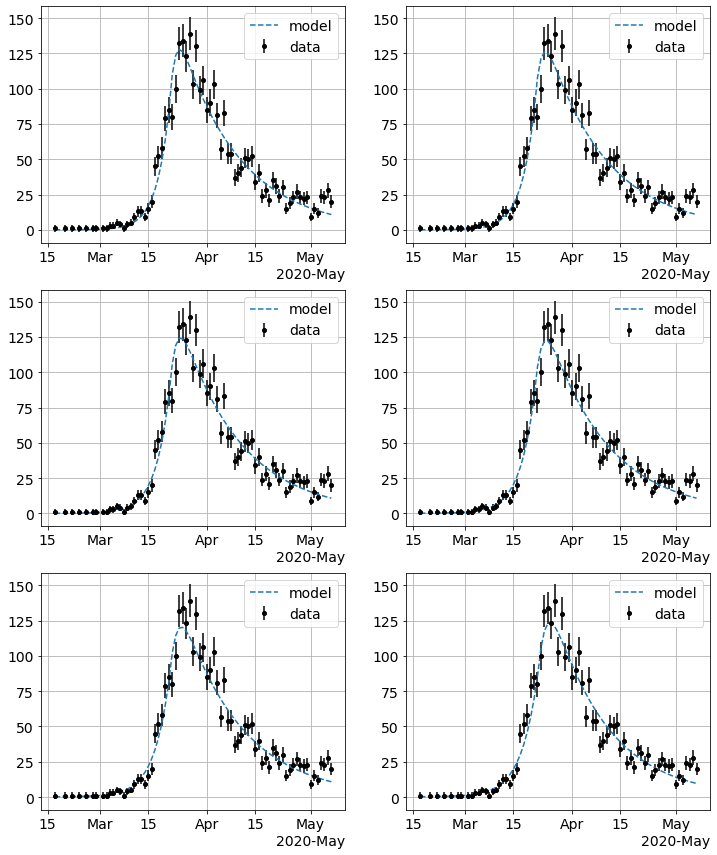

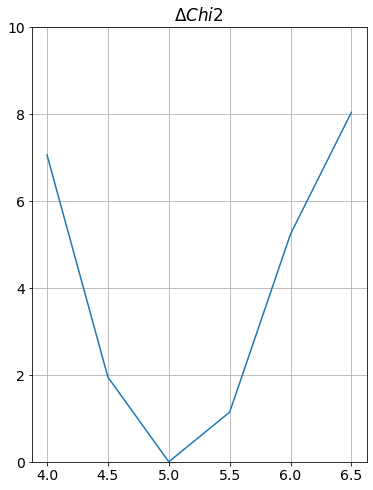

In [134]:
tis = [4., 4.5, 5., 5.5, 6., 6.5]
masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))
dchis = ti_scan(tis, masks)

IntProgress(value=0, max=40)

tr  2.5 , chi2 2.0239127902599043 , pars  {'t0': 14.609382750920886, 'beta': 1.5909446433256564, 'gamma': 0.24882909621585142, 'tr': 2.5, 'ti': 4.5, 'n': 2701743.0, 'phi': 0.059037327802218376, 's1': 0.007758505290888843}
tr  2.5 , chi2 2.009452540530518 , pars  {'t0': 15.593742830381125, 'beta': 1.5935796144588188, 'gamma': 0.24640548426936038, 'tr': 2.5, 'ti': 4.666666666666667, 'n': 2701743.0, 'phi': 0.05539137676112488, 's1': 0.008333942017970086}
tr  2.5 , chi2 1.9993920618946694 , pars  {'t0': 15.464481124495588, 'beta': 1.5968828014080518, 'gamma': 0.24313235840330305, 'tr': 2.5, 'ti': 4.833333333333333, 'n': 2701743.0, 'phi': 0.0663904632679825, 's1': 0.006857434455987403}
tr  2.5 , chi2 1.9952853159813528 , pars  {'t0': 16.56680034155614, 'beta': 1.5994681029521827, 'gamma': 0.24068962194140336, 'tr': 2.5, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06215523449638909, 's1': 0.007587078906700054}
tr  2.5 , chi2 1.9964078428633254 , pars  {'t0': 17.33786272502969, 'beta': 1.601892359352

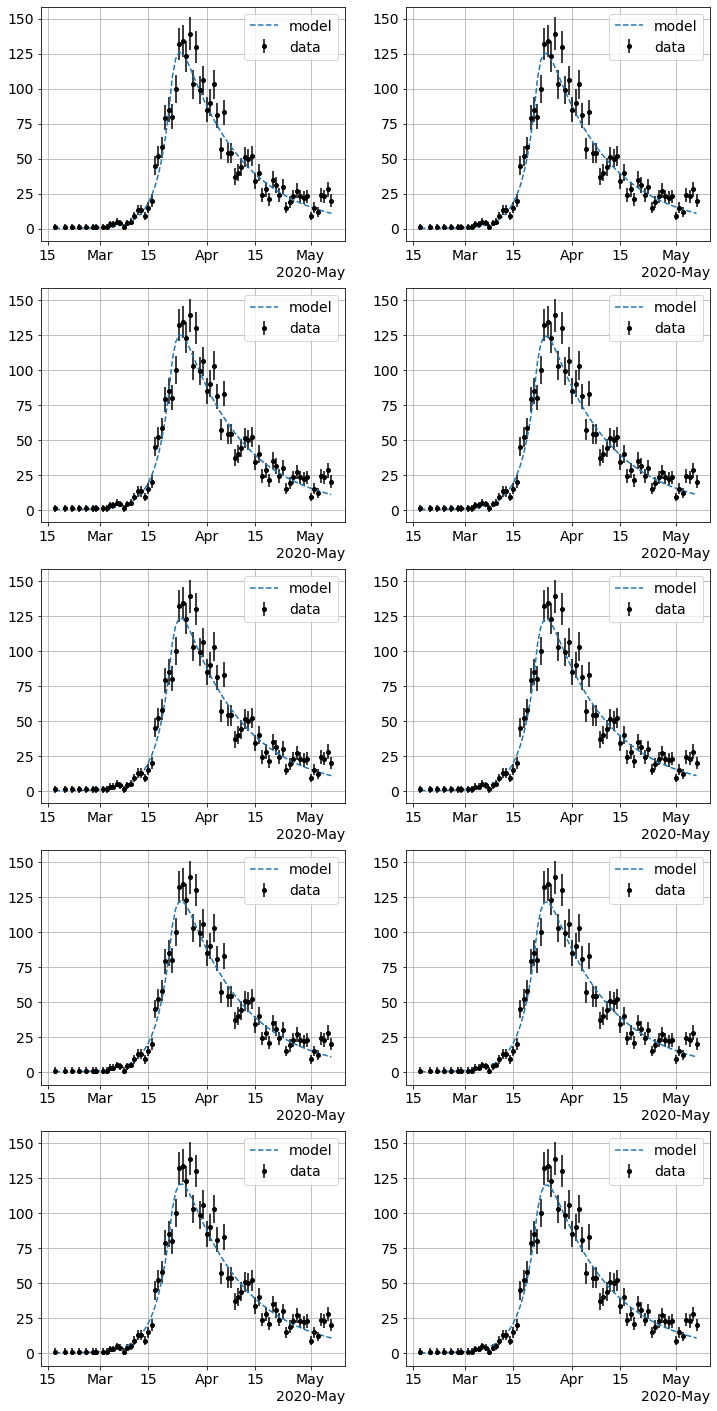

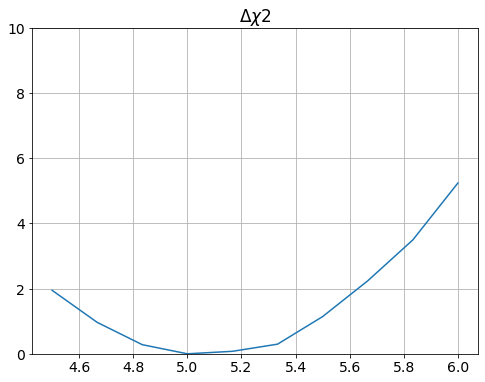

In [140]:
tis = np.linspace(4.5, 6., 10)
masks = 2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))
dchis = ti_scan(tis, masks)

In [ ]:
trs = [1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5]
#masks = 2 * (('t0', 's1', 'phi'), ('beta', 'gamma'))
masks = (('t0', 's1', 'phi'), ('beta', 'gamma'), ('t0',), ('s1', 'beta'), ('phi', 'gamma'))

ncols, nrows = 2, int(len(trs)/2)
if (len(trs) % nrows != 0): nrows += 1

tbar = IntProgress(0, max = len(masks) * len(trs)); display(tbar);
plt.figure(figsize = (6 * ncols, 5 * nrows))
for i, tr in enumerate(trs):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': 5.5, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr/20)}
    for imask in masks:
        tbar.value += 1
        kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    print('tr ', tr, ', chi2', chi2, ', pars ', kpars)
    fmodel = usa.useirqr_fmodel(kpars = kpars)
    ax    = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
    usa.plot_data_model(dates, cases, fmodel)

### Tr 2.5 dias

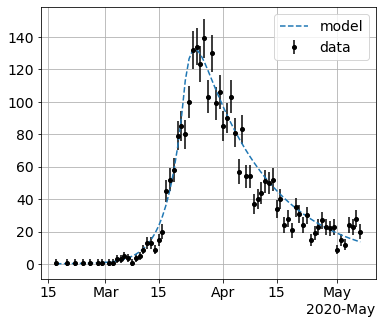

In [54]:
kpars =  {'t0': 18.0, 'beta': 4/2.6, 'gamma': 0.60/2.5, 'tr': 2.5, 'ti': 5.5, 
          'n': n0, 'phi': 0.1, 's1': 0.005}
fmodel = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

1.9976026637745048 {'t0': 18.701497438407188, 'beta': 1.5211916384767554, 'gamma': 0.23292287954566793, 'tr': 2.394235201282477, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.10029477956704794, 's1': 0.005062072753906251}


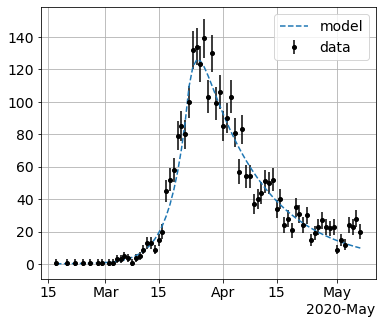

In [55]:
masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)
print(chi2, kpars)

### TR 3 days

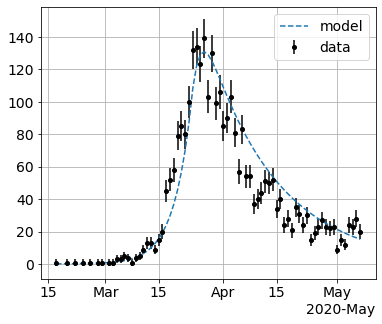

In [31]:
kpars =  {'t0': 18.0, 'beta': 4/3., 'gamma': 0.60/3., 'tr': 3., 'ti': 5.5, 
          'n': n0, 'phi': 0.1, 's1': 0.005}
fmodel = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

1.9929651581631258 {'t0': 18.215600707680057, 'beta': 1.3955817292807873, 'gamma': 0.19184582168825687, 'tr': 3.000494063354576, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.09959922701120377, 's1': 0.005062746047973634}


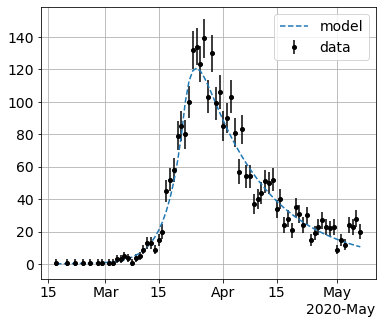

In [32]:
masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)
print(chi2, kpars)

### Tr 4 dias

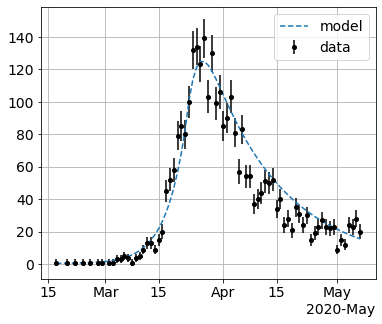

In [50]:
kpars =  {'t0': 25.0, 'beta': 4/4., 'gamma': 0.60/4., 'tr': 4., 'ti': 5.5, 
          'n': n0, 'phi': 0.1, 's1': 0.006}
fmodel = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

2.4524087484514947 {'t0': 26.24982236867718, 'beta': 0.9722449646389582, 'gamma': 0.13478680005006888, 'tr': 3.999979901589726, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.09886647410690785, 's1': 0.006}


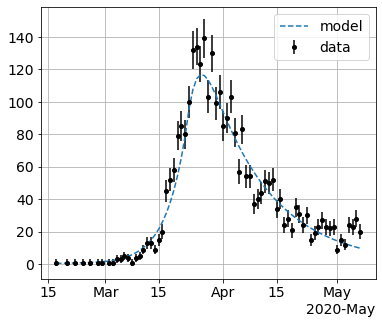

In [51]:
masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)
print(chi2, kpars)

### Tr 5 dias

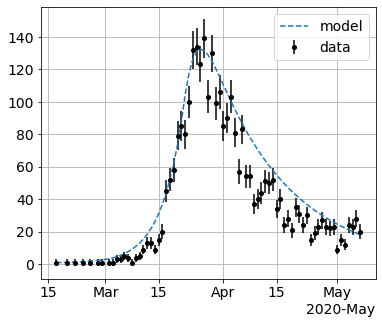

In [45]:
kpars =  {'t0': 32.0, 'beta': 4/5., 'gamma': 0.60/5., 'tr': 5., 'ti': 5.5, 
          'n': n0, 'phi': 0.1, 's1': 0.007}
fmodel = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

3.075214457260115 {'t0': 32.7841388850489, 'beta': 0.7741325455013286, 'gamma': 0.10467092982302635, 'tr': 4.99999952637075, 'ti': 5.5, 'n': 2701743.0, 'phi': 0.09347436655312777, 's1': 0.006403326385631223}


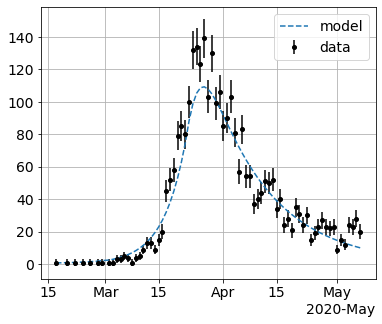

In [46]:
masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqr_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqr_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)
print(chi2, kpars)

2.399302156626143 {'t0': 24.25465849343037, 'beta': 1.1866666666666668, 'gamma': 0.19999999999999998, 'tr': 2.8499999999999996, 'ti': 5.5, 'tm': 2.8499999999999996, 'n': 2701743.0, 'phi': 0.10974372692815254, 's1': 0.004261228183164141}
2.364587857624256 {'t0': 24.25465849343037, 'beta': 1.1042792760873947, 'gamma': 0.1701164167005077, 'tr': 3.2882190814566012, 'ti': 5.5, 'tm': 2.8499999999999996, 'n': 2701743.0, 'phi': 0.10974372692815254, 's1': 0.004261228183164141}


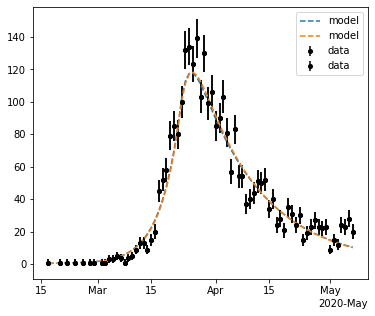

In [396]:
TR = 3.
fi = TR/2.
kpars =  {'t0': 18.0, 'beta': 1.78 / fi, 'gamma': 0.30 / fi, 'tr': 1.9 * fi, 'ti': 5.5, 
         'tm': 1.9 * fi, 'n': n0, 'phi': 0.1, 's1': 0.005}
masks = (('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirq_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirq_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

#### Tr 5 days

4.068445290113628 {'t0': 36.800774201416765, 'beta': 0.712, 'gamma': 0.12, 'tr': 4.75, 'ti': 5.5, 'tm': 4.75, 'n': 2701743.0, 'phi': 0.10026560955462815, 's1': 0.0051284608992039305}
3.8446601185054594 {'t0': 36.800774201416765, 'beta': 0.6743740475867694, 'gamma': 0.09601326021817516, 'tr': 5.536780271873679, 'ti': 5.5, 'tm': 4.75, 'n': 2701743.0, 'phi': 0.10026560955462815, 's1': 0.0051284608992039305}


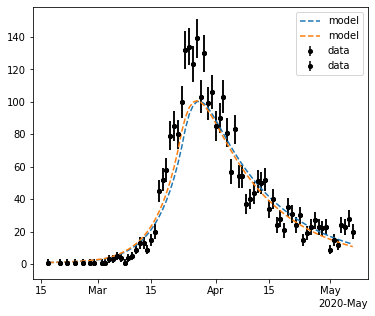

In [397]:
TR = 5.
fi = TR/2.
kpars =  {'t0': 24.0, 'beta': 1.78 / fi, 'gamma': 0.30 / fi, 'tr': 1.9 * fi, 'ti': 5.5, 
         'tm': 1.9 * fi, 'n': n0, 'phi': 0.1, 's1': 0.005}
masks = (('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirq_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirq_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

### Test Q-pandemia with Tq

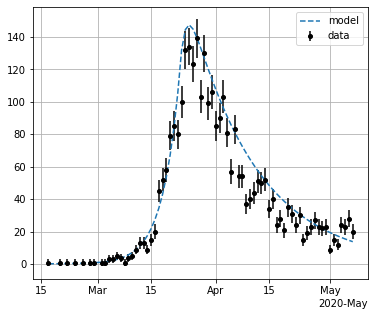

In [389]:
import c19.useir_ana as usa

kpars =  {'t0': 14.0, 'beta': 1.78, 'gamma': 0.30, 'tr': 1.9, 'ti': 5.5, 
         'tm': 1.9, 'n': n0, 'phi': 0.20, 'tq': 41}
fmodel = usa.useirqt_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

2.051871448282016 {'t0': 13.734145649030618, 'beta': 1.78, 'gamma': 0.3, 'tr': 1.9, 'ti': 5.5, 'tm': 1.9, 'n': 2701743.0, 'phi': 0.2082935385511548, 'tq': 39.73530997417242}
1.9818980131259243 {'t0': 13.734145649030618, 'beta': 1.8583592976062198, 'gamma': 0.31065122055624594, 'tr': 1.7602133194266407, 'ti': 5.5, 'tm': 1.9, 'n': 2701743.0, 'phi': 0.2082935385511548, 'tq': 39.73530997417242}
1.9818880342075975 {'t0': 13.70101946205342, 'beta': 1.8583592976062198, 'gamma': 0.31065122055624594, 'tr': 1.7602133194266407, 'ti': 5.5, 'tm': 1.9, 'n': 2701743.0, 'phi': 0.20819007649059534, 'tq': 39.68808831755034}
1.9818780683053823 {'t0': 13.70101946205342, 'beta': 1.858679307199952, 'gamma': 0.3107082702249273, 'tr': 1.7598329422204746, 'ti': 5.5, 'tm': 1.9, 'n': 2701743.0, 'phi': 0.20819007649059534, 'tq': 39.68808831755034}


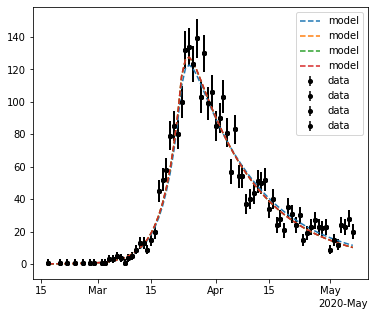

In [390]:
TR = 2.
fi = TR/2.
kpars =  {'t0': 14.0, 'beta': 1.78 / fi, 'gamma': 0.30 / fi, 'tr': 1.9 * fi, 'ti': 5.5, 
         'tm': 1.9 * fi, 'n': n0, 'phi': 0.20, 'tq': 40.}
masks = 2*(('t0', 'phi', 'tq'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirqt_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqt_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

10.55481933108041 {'t0': 12.050181206258134, 'beta': 1.1866666666666668, 'gamma': 0.19999999999999998, 'tr': 2.8499999999999996, 'ti': 5.5, 'tm': 2.8499999999999996, 'n': 2701743.0, 'phi': 0.2773063475708747, 'tq': 44.83615976477428}
7.193682995936484 {'t0': 12.050181206258134, 'beta': 2.664530227214456, 'gamma': 0.5732055561142975, 'tr': 0.07220850084472026, 'ti': 5.5, 'tm': 2.8499999999999996, 'n': 2701743.0, 'phi': 0.2773063475708747, 'tq': 44.83615976477428}
3.0467978644278424 {'t0': 15.666001467415423, 'beta': 2.664530227214456, 'gamma': 0.5732055561142975, 'tr': 0.07220850084472026, 'ti': 5.5, 'tm': 2.8499999999999996, 'n': 2701743.0, 'phi': 0.37643088663465296, 'tq': 43.54071178459779}
2.454674433568931 {'t0': 15.666001467415423, 'beta': 2.6364382932507464, 'gamma': 0.6430185454209691, 'tr': 0.07392908172237163, 'ti': 5.5, 'tm': 2.8499999999999996, 'n': 2701743.0, 'phi': 0.37643088663465296, 'tq': 43.54071178459779}


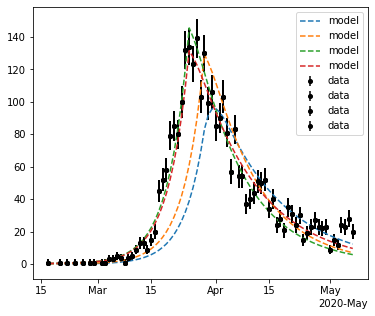

In [391]:
TR = 3.
fi = TR/2.
kpars =  {'t0': 14.0, 'beta': 1.78 / fi, 'gamma': 0.30 / fi, 'tr': 1.9 * fi, 'ti': 5.5, 
         'tm': 1.9 * fi, 'n': n0, 'phi': 0.20, 'tq': 40.}
masks = 2*(('t0', 'phi', 'tq'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirqt_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqt_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

4.068445290003132 {'t0': 36.60149070748432, 'beta': 0.712, 'gamma': 0.12, 'tr': 4.75, 'ti': 5.5, 'tm': 4.75, 'n': 2701743.0, 'phi': 0.10026539215443309, 'tq': 63.07904506109412}
3.8217617070673486 {'t0': 36.60149070748432, 'beta': 0.6999572857151837, 'gamma': 0.09979170373126338, 'tr': 5.02777449748443, 'ti': 5.5, 'tm': 4.75, 'n': 2701743.0, 'phi': 0.10026539215443309, 'tq': 63.07904506109412}
3.816152360206814 {'t0': 36.630334708484064, 'beta': 0.6999572857151837, 'gamma': 0.09979170373126338, 'tr': 5.02777449748443, 'ti': 5.5, 'tm': 4.75, 'n': 2701743.0, 'phi': 0.09907048254581272, 'tq': 63.22978253429228}
3.810501828527173 {'t0': 36.630334708484064, 'beta': 0.7025482585304919, 'gamma': 0.10043692332475605, 'tr': 5.003621337638419, 'ti': 5.5, 'tm': 4.75, 'n': 2701743.0, 'phi': 0.09907048254581272, 'tq': 63.22978253429228}


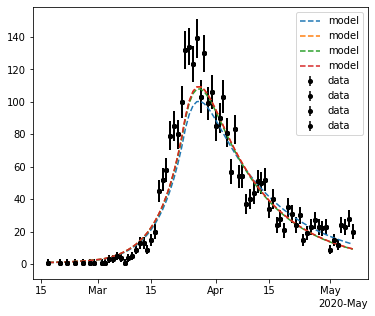

In [392]:
TR = 5.
fi = TR/2.
kpars =  {'t0': 14.0, 'beta': 1.78 / fi, 'gamma': 0.30 / fi, 'tr': 1.9 * fi, 'ti': 5.5, 
         'tm': 1.9 * fi, 'n': n0, 'phi': 0.20, 'tq': 40.}
masks = 2*(('t0', 'phi', 'tq'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirqt_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqt_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

### Test weinbull distribution

7.633373286477691
9.349011227337892 58.40231172451915


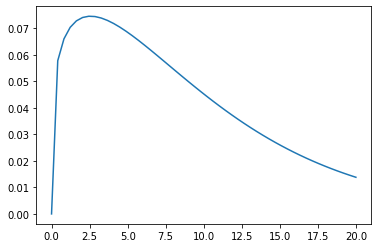

In [340]:
ts = np.linspace(0., 50)
c0, tr, fi = 1.23, 10.0, 1.0
wb = stats.weibull_min(c0, scale = fi * tr )
ts = np.linspace(0., 20)
nmean = np.sum(ts * wb.pdf(ts)) / np.sum(wb.pdf(ts))
print(nmean)
plt.plot(ts, wb.pdf(ts));
mean, var = stats.weibull_min.stats(c0, scale = tr, moments = 'mv')
print(mean, var)

In [21]:
tR = recovery_time(hgi)

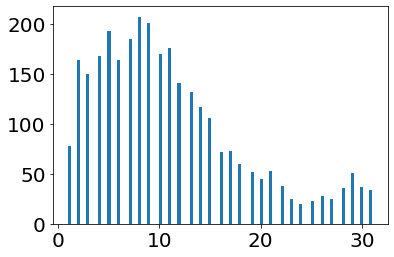

In [24]:
plt.hist(tR, 100);

In [25]:
tD, nH, nU = hosp_uci(hgi) 

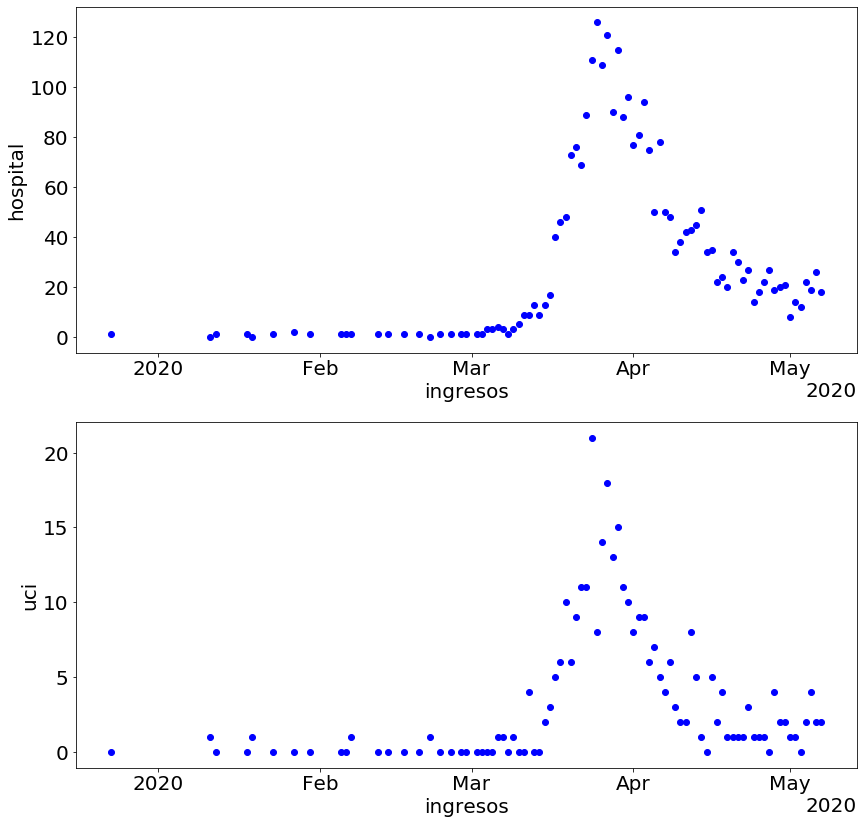

In [26]:
plot_nh_nu(tD, nH, nU, figsize=(14,14))

In [27]:
dfp = pd.read_csv(fp, sep='|')
dfp.head()

,Paciente,Ingreso,Edad,Sexo,Alta,Code,Registro,ZIP,Unnamed: 8
0,1,25/03/2020,102,Mujer,30/03/2020,EXITUS,"A.S. OURENSE, VERIN E O BARCO",32633.0,NaN
1,2,27/03/2020,101,Mujer,31/03/2020,EXITUS,A.S. VIGO,36205.0,NaN
2,3,27/03/2020,100,Mujer,19/04/2020,EXITUS,"A.S. OURENSE, VERIN E O BARCO",32800.0,NaN
3,4,01/04/2020,99,Mujer,24/04/2020,EXITUS,A.S. A CORU�A E CEE,15009.0,NaN
4,5,28/03/2020,99,Mujer,05/04/2020,EXITUS,"A.S. OURENSE, VERIN E O BARCO",32710.0,NaN


In [28]:
dfp = hg_get_data_pacientes(fp)

In [29]:
dfp.head()

,pacienteID,ingreso,alta,edad,sexo,code
0,1,2020-03-25,2020-03-30,102,Mujer,EXITUS
1,2,2020-03-27,2020-03-31,101,Mujer,EXITUS
2,3,2020-03-27,2020-04-19,100,Mujer,EXITUS
3,4,2020-04-01,2020-04-24,99,Mujer,EXITUS
4,5,2020-03-28,2020-04-05,99,Mujer,EXITUS


In [30]:
dfp.tail()

,pacienteID,ingreso,alta,edad,sexo,code
10449,10450,2020-04-25,2030-01-01,17,Hombre,NaN
10450,10451,2020-04-25,2030-01-01,18,Hombre,NaN
10451,10452,2020-04-23,2030-01-01,71,Hombre,NaN
10452,10453,2020-04-29,2030-01-01,44,Hombre,NaN
10453,10454,2020-05-02,2030-01-01,34,Mujer,NaN


In [125]:
print(set(dfp.code))

{nan, 'UCI', 'EXITUS', 'HOS'}


In [31]:
def exitus_group(dfp):
    df    = dfp.loc[dfp.code == "EXITUS", ('pacienteID', 'ingreso', 'alta', 'edad', 'sexo')]
    return df

In [32]:
dfe = exitus_group(dfp)

In [33]:
dfe.tail()

,pacienteID,ingreso,alta,edad,sexo
539,540,2020-04-07,2020-04-17,84,Hombre
540,541,2020-03-23,2020-03-24,85,Hombre
541,542,2020-04-07,2020-03-15,81,Hombre
542,543,2020-03-19,2020-04-11,73,Mujer
543,544,2020-03-23,2020-03-31,78,Hombre


,pacienteID,ingreso,alta,edad,sexo,code
0,1,2020-03-25,2020-03-30,102,Mujer,EXITUS
1,2,2020-03-27,2020-03-31,101,Mujer,EXITUS
2,3,2020-03-27,2020-04-19,100,Mujer,EXITUS
3,4,2020-04-01,2020-04-24,99,Mujer,EXITUS
4,5,2020-03-28,2020-04-05,99,Mujer,EXITUS


5246.0
9.842401500938086 8.02397459751782 533


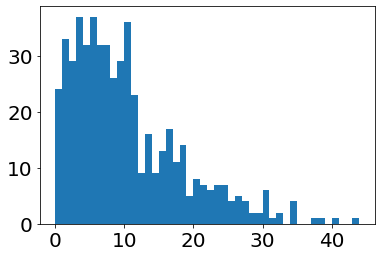

In [139]:
des = (dfe.alta.values - dfe.ingreso.values)/np.timedelta64(1, 'D')
des = des[des >= 0]
n   = np.max(des)
print(np.sum(des))
print(np.mean(des), np.std(des), len(des))
plt.hist(des, int(n), (0, n));

In [130]:
import scipy.stats as stats

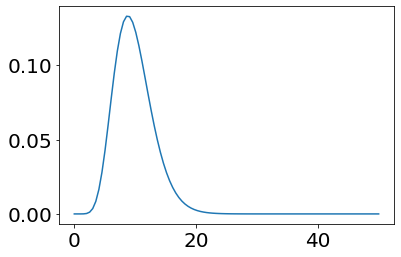

In [136]:
fgamma = stats.gamma(9.8)
xs = np.linspace(0., 50, 100)
plt.plot(xs, fgamma.pdf(xs));

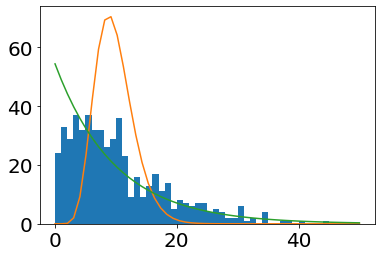

In [142]:
ntot = len(des)
n0   = 50
plt.hist(des, n0, (0, n0));
fgamma = stats.gamma(9.8)
xs = np.linspace(0., n0, n0)
plt.plot(xs, ntot * fgamma.pdf(xs));

ffun = stats.expon(scale = 9.8)
xs = np.linspace(0., n0, n0)
plt.plot(xs, ntot * ffun.pdf(xs));

In [34]:
thE = exitus_time(dfp, sexo='Hombre')

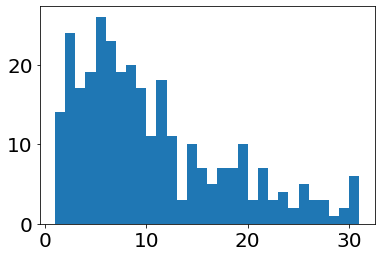

In [39]:
plt.hist(thE, 30);

In [41]:
np.mean(thE), np.std(thE)

(10.13029315960912, 7.3822545115306815)

In [307]:
tmE = exitus_time(dfp, sexo='Mujer')

(array([34., 42., 38., 49., 15., 22.,  8., 12.,  6., 11.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

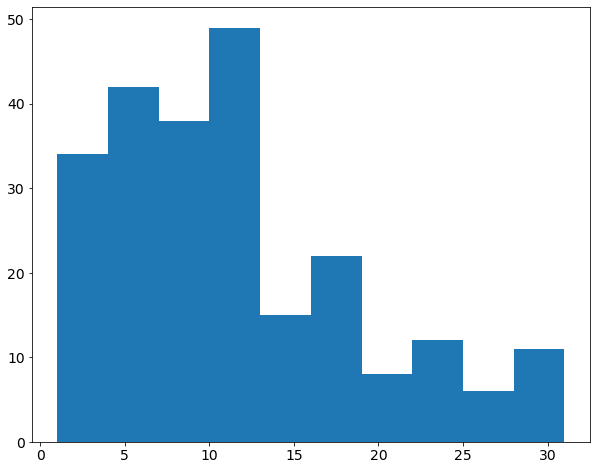

In [308]:
plt.hist(tmE)

In [309]:
tmA = exitus_time(dfp, sexo='all')

(array([ 89., 110.,  94.,  89.,  35.,  41.,  28.,  21.,  17.,  20.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

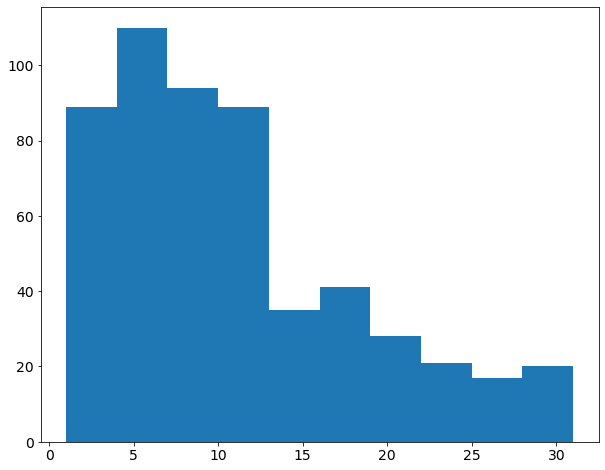

In [310]:
plt.hist(tmA)

In [311]:
ex = exitus(dfp, sexo='all',groupby='edad')

 exitus total = 544 fraction = 0.05203749760857088


In [312]:
dfc = exitus(dfp, sexo='all',groupby='ingreso', datestamp=True)

 exitus total = 544 fraction = 0.05203749760857088


In [313]:
dfc.head()

ingreso
2020-03-11    1
2020-03-12    1
2020-03-13    3
2020-03-15    3
2020-03-16    7
Name: pacienteID, dtype: int64

In [314]:
ex.head()

edad
35    1
37    2
45    2
48    1
50    2
Name: pacienteID, dtype: int64

In [315]:
dfc2 = exitus(dfp, sexo='all',groupby='ingreso', datestamp=False)

 exitus total = 544 fraction = 0.05203749760857088


In [316]:
dfc2.head()

0    1
1    1
2    3
3    3
4    7
dtype: int64

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


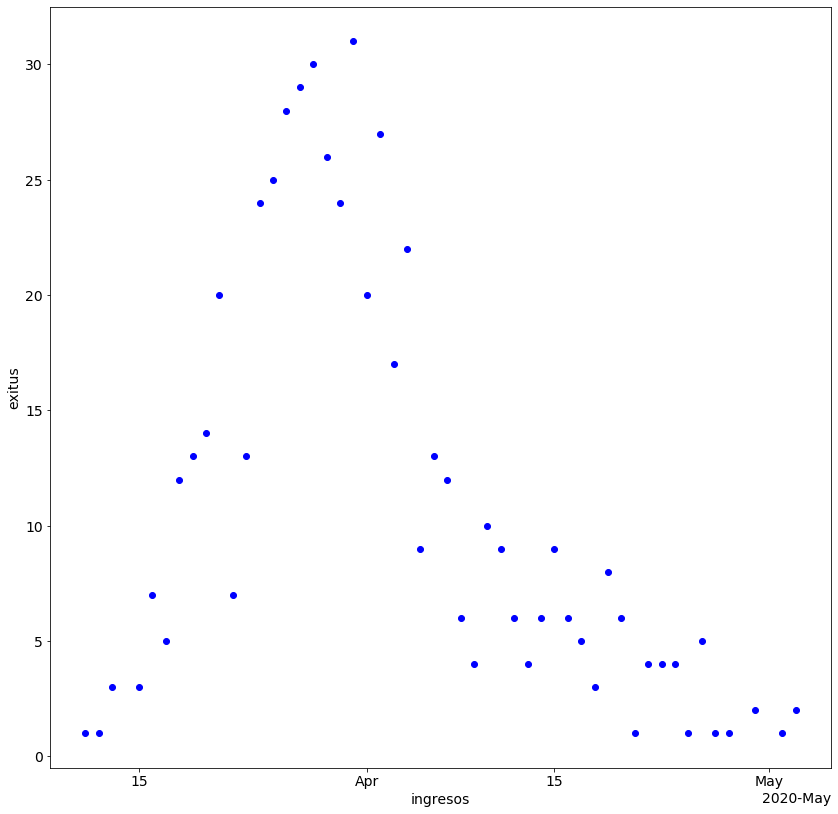

In [317]:
plot_XY_series(dfc,xlabel='ingresos',ylabel='exitus',figsize=(14,14))

[38.04545454545455, 44.13636363636364, 50.22727272727273, 56.31818181818181, 62.40909090909091, 68.5, 74.5909090909091, 80.68181818181817, 86.77272727272727, 92.86363636363636, 98.95454545454545]
[ 2.          2.          1.33333333  2.83333333  3.          7.
 11.         17.         26.         17.5         4.14285714]


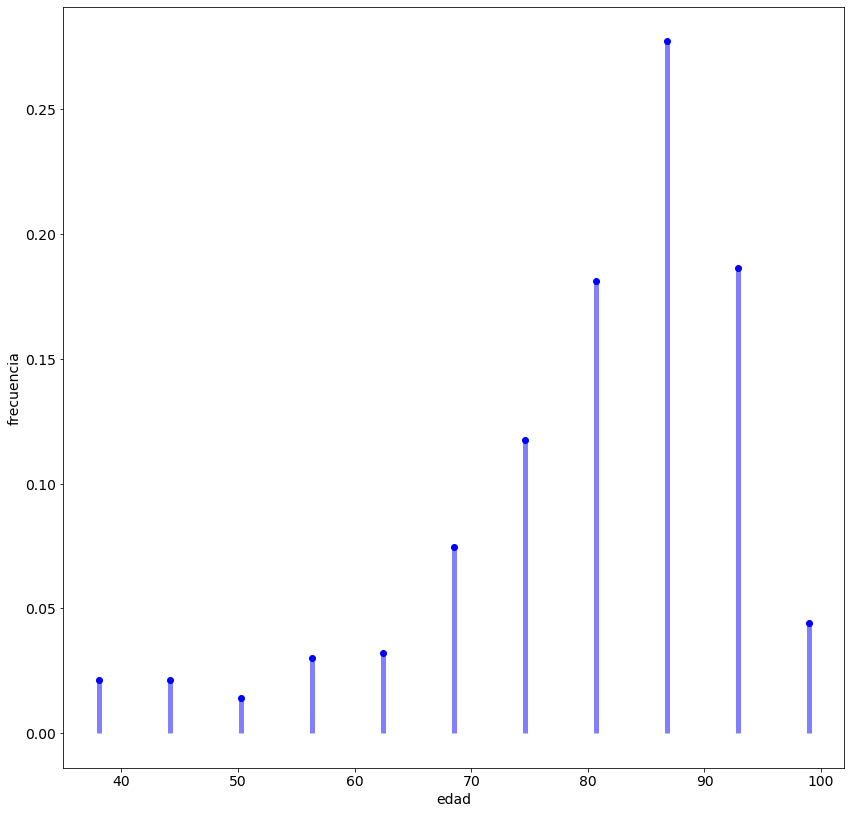

In [318]:
hist_XY_series(ex,xlabel='edad',ylabel='frecuencia', bins=12, figsize=(14,14))

[2.7777777777777777, 8.333333333333332, 13.888888888888888, 19.444444444444443, 25.0, 30.555555555555554, 36.11111111111111, 41.666666666666664, 47.22222222222222]
[ 3.8        13.16666667 27.2        24.16666667 12.4         6.5
  6.2         3.33333333  2.        ]


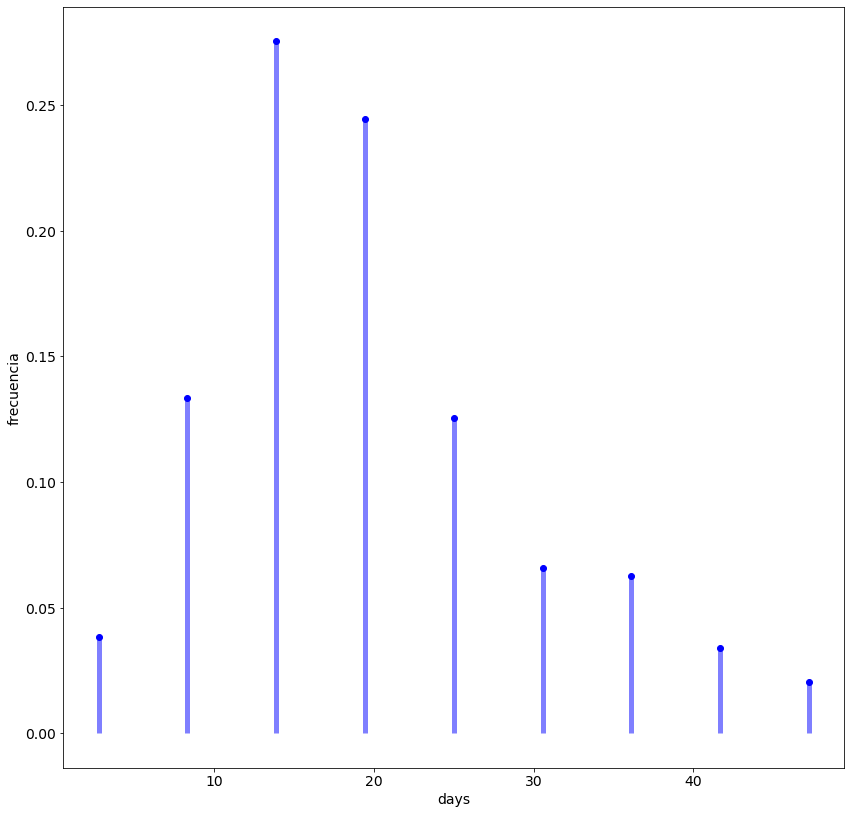

In [319]:
hist_XY_series(dfc2,xlabel='days',ylabel='frecuencia',figsize=(14,14))

# Read age data

In [279]:
datapath="/Users/jjgomezcadenas/Projects/Development/C19/data/"
file = "edad_poblacion.csv"
ff =f'{datapath}/{file}'
dfa = pd.read_csv(ff, sep=';')

In [228]:
dfa.head()

,Sexo,Comunidades y provincias,Edad (hasta 100 y más),Total
0,Ambos sexos,TOTAL ESPAÑA,Total,47.431.256
1,Ambos sexos,TOTAL ESPAÑA,0-4,1.974.809
2,Ambos sexos,TOTAL ESPAÑA,5-9,2.324.559
3,Ambos sexos,TOTAL ESPAÑA,10-14,2.522.754
4,Ambos sexos,TOTAL ESPAÑA,15-19,2.387.556


In [280]:
df = hg_get_data_age(ff)

In [281]:
df.head()

,sexo,ca,edad,poblacion
0,Ambos sexos,TOTAL ESPAÑA,Total,47.431.256
1,Ambos sexos,TOTAL ESPAÑA,0-4,1.974.809
2,Ambos sexos,TOTAL ESPAÑA,5-9,2.324.559
3,Ambos sexos,TOTAL ESPAÑA,10-14,2.522.754
4,Ambos sexos,TOTAL ESPAÑA,15-19,2.387.556


In [282]:
dfa = select_age_by_CA_and_sex(df, sexo='Ambos sexos',CA = 'TOTAL ESPAÑA')

In [283]:
dfa

,arange,amean,poblacion
0,"(0, 4)",2.0,1974809.0
1,"(5, 9)",7.0,2324559.0
2,"(10, 14)",12.0,2522754.0
3,"(15, 19)",17.0,2387556.0
4,"(20, 24)",22.0,2359591.0
5,"(25, 29)",27.0,2582946.0
6,"(30, 34)",32.0,2838372.0
7,"(35, 39)",37.0,3389813.0
8,"(40, 44)",42.0,3995052.0
9,"(45, 49)",47.0,3894528.0


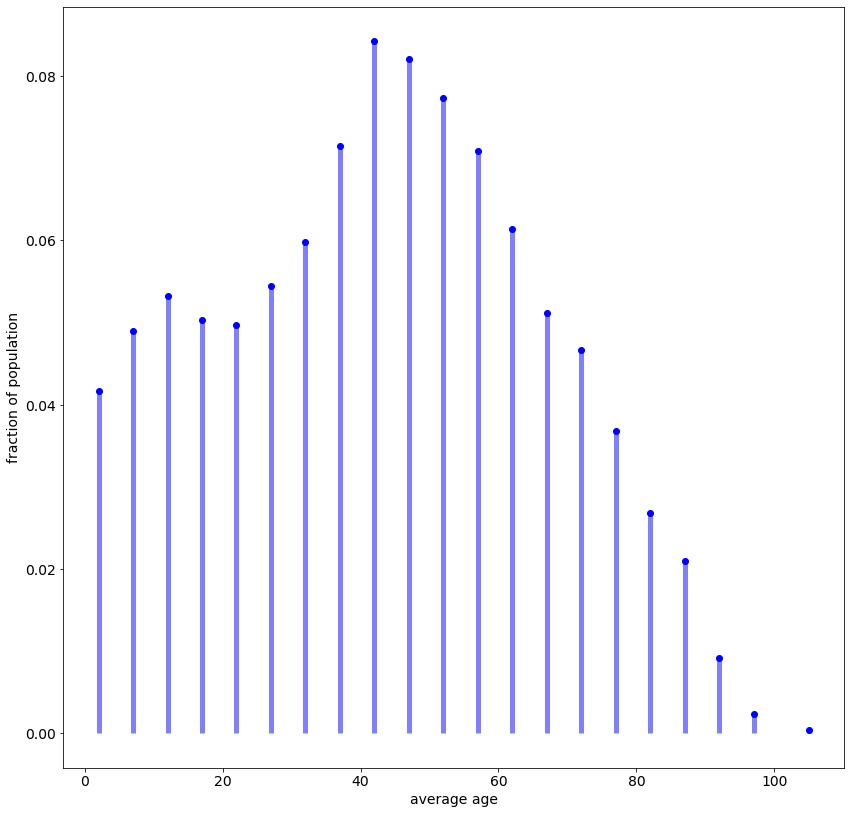

In [284]:
plot_pop_age(dfa, figsize=(14,14))